# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
%%javascript
// Go to Running cell shortcut
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Alt-I', {
    help : 'Go to Running cell',
    help_index : 'zz',
    handler : function (event) {
        setTimeout(function() {
            // Find running cell and click the first one
            if ($('.running').length > 0) {
                //alert("found running cell");
                $('.running')[0].scrollIntoView();
            }}, 250);
        return false;
    }
});

<IPython.core.display.Javascript object>

In [2]:
# import libraries here; add more as necessary
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pylab
import markdown
import pprint as pp
from ast import literal_eval
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans  
from sklearn.metrics.pairwise import euclidean_distances

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
#Load Data Dictionary
f = open('Data_Dictionary.md', 'r')
datadic = markdown.markdown( f.read() )

display(HTML(datadic))

In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info.name="Feature info"
a=pd.options.display.max_rows
pd.options.display.max_rows = 100
print(feat_info)
pd.options.display.max_rows = a

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

Conclusions from the markdown(feat_info) above: 

First, ordinals we are not going to apply get_dummies() on. We are just going to apply it to the categoricals. We have to look into to mixed and numeric types as they are vague on what it means. I would guess numerics are perhaps floats like length or something. And then we do not want to apply get_dummies on them.

As you can see from the missing_or_unknown column the ONLY columns where we have not got '-1' as NaN is for CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015 and OST_WEST_KZ, where NaN is represented by 'X' or 'XX'.

Also, from the Data_Dictionary-markdown above you can see that 'X' or 'XX' in these columns are defined as NaN so its safe to convert them into NaN later on. 


In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias.name="AZDIAS"

#Load in customers
custs = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
custs.name="Customers"

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.info())
#print(custs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
'''
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
'''

"\npd.set_option('display.max_rows', 500)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)\n"

In [8]:
azdias.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AGER_TYP,-1,-1,-1,2,-1,3,-1,-1,-1,-1,0,-1,-1,-1,-1
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Remove all NaNs for all Features into np.nan in one go!
# Except for CAMEO_DEU_2015, OST_WEST_KZ, CAMEO_DEUG_2015, CAMEO_INTL_2015
for i in ['categorical','mixed','ordinal','numeric']:
    print('{}: {} columns'.format(i, feat_info[feat_info['type']==i].shape[0]))

for i,j in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    print(i,j)
    if (i == 'CAMEO_DEU_2015' or i=='CAMEO_DEUG_2015' or i=='CAMEO_INTL_2015' or i == 'OST_WEST_KZ'):
        print('Skip CAMEO_???_2015/OST_WEST_KZ')
    else:
        k = literal_eval(j)
        for l in k:
            azdias[i].replace(l,-1, regex=True, inplace=True) 
            custs[i].replace(l,-1, regex=True, inplace=True) 

categorical: 21 columns
mixed: 7 columns
ordinal: 49 columns
numeric: 7 columns
AGER_TYP [-1,0]
ALTERSKATEGORIE_GROB [-1,0,9]
ANREDE_KZ [-1,0]
CJT_GESAMTTYP [0]
FINANZ_MINIMALIST [-1]
FINANZ_SPARER [-1]
FINANZ_VORSORGER [-1]
FINANZ_ANLEGER [-1]
FINANZ_UNAUFFAELLIGER [-1]
FINANZ_HAUSBAUER [-1]
FINANZTYP [-1]
GEBURTSJAHR [0]
GFK_URLAUBERTYP []
GREEN_AVANTGARDE []
HEALTH_TYP [-1,0]
LP_LEBENSPHASE_FEIN [0]
LP_LEBENSPHASE_GROB [0]
LP_FAMILIE_FEIN [0]
LP_FAMILIE_GROB [0]
LP_STATUS_FEIN [0]
LP_STATUS_GROB [0]
NATIONALITAET_KZ [-1,0]
PRAEGENDE_JUGENDJAHRE [-1,0]
RETOURTYP_BK_S [0]
SEMIO_SOZ [-1,9]
SEMIO_FAM [-1,9]
SEMIO_REL [-1,9]
SEMIO_MAT [-1,9]
SEMIO_VERT [-1,9]
SEMIO_LUST [-1,9]
SEMIO_ERL [-1,9]
SEMIO_KULT [-1,9]
SEMIO_RAT [-1,9]
SEMIO_KRIT [-1,9]
SEMIO_DOM [-1,9]
SEMIO_KAEM [-1,9]
SEMIO_PFLICHT [-1,9]
SEMIO_TRADV [-1,9]
SHOPPER_TYP [-1]
SOHO_KZ [-1]
TITEL_KZ [-1,0]
VERS_TYP [-1]
ZABEOTYP [-1,9]
ALTER_HH [0]
ANZ_PERSONEN []
ANZ_TITEL []
HH_EINKOMMEN_SCORE [-1,0]
KK_KUNDENTYP [-1]
W_KEIT_KI

In [8]:
#We can proceed with converting all -1 into pure NaNs!
azdias.replace(-1,np.nan, regex=True, inplace=True) 
azdias.replace('-1',np.nan, regex=True, inplace=True) 
custs.replace(-1,np.nan, regex=True, inplace=True) 
custs.replace('-1',np.nan, regex=True, inplace=True) 

In [9]:
#Convert OST_WEST_KZ from NaN->-1, "W"->0, "O"->1 and by this we prepare one hot encode and enble chart for OST_WEST_KZ 
#azdias['OST_WEST_KZ'].replace("W", 0, regex=True, inplace=True) 
#azdias['OST_WEST_KZ'].replace("O", 1, regex=True, inplace=True) 
#custs['OST_WEST_KZ'].replace("W", 0, regex=True, inplace=True) 
#custs['OST_WEST_KZ'].replace("O", 1, regex=True, inplace=True)

In [ ]:
azdias.replace('X',np.nan, regex=True, inplace=True) 
azdias.replace('XX',np.nan, regex=True, inplace=True) 
custs.replace('X',np.nan, regex=True, inplace=True) 
custs.replace('XX',np.nan, regex=True, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
def colCandidateToDrop(df, cutoff, nameOfDf):
    aa=df.shape[0]
    print('')
    print('>>>>>> {} Columns candidates with missing above: {:.0f}%'.format(nameOfDf, 100.*cutoff))
    for i in df.columns.values:
        if (azdias[i].isnull().sum()/aa>cutoff):
            print(i)
            
for i in range(5):
    colCandidateToDrop(azdias, (i+3.0)/10.0, 'AZDIAS')

for i in range(5):
    colCandidateToDrop(custs, (i+3.0)/10.0, 'CUSTS')


>>>>>> AZDIAS Columns candidates with missing above: 30%
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX

>>>>>> AZDIAS Columns candidates with missing above: 40%
AGER_TYP
GEBURTSJAHR
TITEL_KZ
KK_KUNDENTYP
KBA05_BAUMAX

>>>>>> AZDIAS Columns candidates with missing above: 50%
AGER_TYP
TITEL_KZ
KK_KUNDENTYP
KBA05_BAUMAX

>>>>>> AZDIAS Columns candidates with missing above: 60%
AGER_TYP
TITEL_KZ
KK_KUNDENTYP

>>>>>> AZDIAS Columns candidates with missing above: 70%
AGER_TYP
TITEL_KZ

>>>>>> CUSTS Columns candidates with missing above: 30%
AGER_TYP
GEBURTSJAHR
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05

In [14]:
print('azdias - No NaN/NULLs: {}'.format(azdias.isnull().sum().sum()))
print("azdias - No Rows with NaN/NULL: {}".format(azdias.isnull().T.any().T.sum()))

azdias - No NaN/NULLs: 8373929
azdias - No Rows with NaN/NULL: 891078


In [15]:
def print_distribution(data):
    for i, feature in enumerate(data.columns.values):
        if (feature not in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', "OST_WEST_KZ"]):
            print("{} NaN: {:.1f}%".format(feature, data[feature][np.isnan(data[feature])].shape[0]/data.shape[0]*100))
print_distribution(azdias)
print_distribution(custs)

AGER_TYP NaN: 77.0%
ALTERSKATEGORIE_GROB NaN: 0.3%
ANREDE_KZ NaN: 0.0%
CJT_GESAMTTYP NaN: 0.5%
FINANZ_MINIMALIST NaN: 0.0%
FINANZ_SPARER NaN: 0.0%
FINANZ_VORSORGER NaN: 0.0%
FINANZ_ANLEGER NaN: 0.0%
FINANZ_UNAUFFAELLIGER NaN: 0.0%
FINANZ_HAUSBAUER NaN: 0.0%
FINANZTYP NaN: 0.0%
GEBURTSJAHR NaN: 44.0%
GFK_URLAUBERTYP NaN: 0.5%
GREEN_AVANTGARDE NaN: 0.0%
HEALTH_TYP NaN: 12.5%
LP_LEBENSPHASE_FEIN NaN: 11.0%
LP_LEBENSPHASE_GROB NaN: 10.6%
LP_FAMILIE_FEIN NaN: 8.7%
LP_FAMILIE_GROB NaN: 8.7%
LP_STATUS_FEIN NaN: 0.5%
LP_STATUS_GROB NaN: 0.5%
NATIONALITAET_KZ NaN: 12.2%
PRAEGENDE_JUGENDJAHRE NaN: 12.1%
RETOURTYP_BK_S NaN: 0.5%
SEMIO_SOZ NaN: 0.0%
SEMIO_FAM NaN: 0.0%
SEMIO_REL NaN: 0.0%
SEMIO_MAT NaN: 0.0%
SEMIO_VERT NaN: 0.0%
SEMIO_LUST NaN: 0.0%
SEMIO_ERL NaN: 0.0%
SEMIO_KULT NaN: 0.0%
SEMIO_RAT NaN: 0.0%
SEMIO_KRIT NaN: 0.0%
SEMIO_DOM NaN: 0.0%
SEMIO_KAEM NaN: 0.0%
SEMIO_PFLICHT NaN: 0.0%
SEMIO_TRADV NaN: 0.0%
SHOPPER_TYP NaN: 12.5%
SOHO_KZ NaN: 8.2%
TITEL_KZ NaN: 99.8%
VERS_TYP NaN: 12.5%
ZA

In [16]:
'''
Definite candidates to drop are (as the np.NaN percentage is so hig compared to the other columns:

For the population AZDIAS:
AGER_TYP
ALTER_HH
GEBURTSJAHR
KBA05_BAUMAX
KK_KUNDENTYP
TITEL_KZ

For the sample Customers:
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
W_KEIT_KIND_HH
KBA05_BAUMAX
KKK
REGIOTYP
'''

'\nDefinite candidates to drop are (as the np.NaN percentage is so hig compared to the other columns:\n\nFor the population AZDIAS:\nAGER_TYP\nALTER_HH\nGEBURTSJAHR\nKBA05_BAUMAX\nKK_KUNDENTYP\nTITEL_KZ\n\nFor the sample Customers:\nAGER_TYP\nGEBURTSJAHR\nTITEL_KZ\nALTER_HH\nKK_KUNDENTYP\nW_KEIT_KIND_HH\nKBA05_BAUMAX\nKKK\nREGIOTYP\n'

In [ ]:
column_nans = azdias.isnull().mean()
plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')

In [ ]:
#We see from the chart above that we have six distinct outliers given by the columns above (>0.2). We will thus drop them. 
#First we will find their names (columns names)

In [ ]:
column_nans[column_nans>0.2]

In [20]:
#We drop them below after some more scrutinizing of the data

AGER_TYP
PLEASE NOTE: 0=data, 1=NaN/Null


/smalltank/udacity/miniconda/lib/python3.6/site-packages/numpy/lib/histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

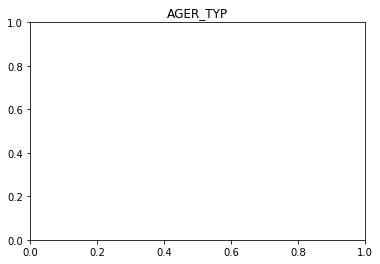

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def draw_distribution(data):
    for i, feature in enumerate(data.columns.values):
        print(feature)
        print("PLEASE NOTE: 0=data, 1=NaN/Null")
        if (feature not in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', "OST_WEST_KZ"]):
            pylab.figure()
            pylab.title(feature)
#            pylab.hist(data[feature][~np.isnan(data[feature])])
#            pylab.hist(data[feature][data[feature]>0])
            pylab.hist(pd.isnull(data[feature]))
            pylab.show()
        else:
            print('')
draw_distribution(azdias)

In [ ]:
draw_distribution(custs)

In [ ]:
#As the hist diagrams where hard to follow and when doing runs with another environment 
#the hist-functionality fails because of depricated functionality within numpy I 
#also did heatmap that are much more intuitive I think.
fig, ax = plt.subplots(figsize=(30,30))   
sns.heatmap(custs.isnull(), cbar=False, ax=ax)
plt.show()
plt.close()

In [ ]:
#We see that many of the rows that have missing data is actually missing data in other columns as well, 
#i.e. missing data is correlated row-vise
#(See white horizontal pattern created above)
#We will drop columns that create white vertical patterns, e.g. TITEL_KZ, KK_KUNDENTYP and AGER_TYP, 
#i.e. concentrations of column data missing

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(azdias.isnull(), cbar=False, ax=ax)
plt.show()
plt.close()

In [ ]:
#Now we drop the columns found by column_nans[column_nans>0.2] as stated above
azdias.drop('AGER_TYP', inplace=True, axis=1) 
custs.drop('AGER_TYP', inplace=True, axis=1) 
azdias.drop('GEBURTSJAHR', inplace=True, axis=1) 
custs.drop('GEBURTSJAHR', inplace=True, axis=1) 
azdias.drop('TITEL_KZ', inplace=True, axis=1) 
custs.drop('TITEL_KZ', inplace=True, axis=1) 
azdias.drop('ALTER_HH', inplace=True, axis=1) 
custs.drop('ALTER_HH', inplace=True, axis=1) 
azdias.drop('KK_KUNDENTYP', inplace=True, axis=1) 
custs.drop('KK_KUNDENTYP', inplace=True, axis=1) 
azdias.drop('KBA05_BAUMAX', inplace=True, axis=1) 
custs.drop('KBA05_BAUMAX', inplace=True, axis=1) 

In [ ]:
#This results in this! No "white vertical lines" showing missing data. ONLY the rows left to clean
fig, ax = plt.subplots(figsize=(30,30))   
sns.heatmap(custs.isnull(), cbar=False, ax=ax)
plt.show()
plt.close()

In [ ]:
#This results in this! No apparent "white vertical lines" showing missing data. ONLY the rows left to clean
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(azdias.isnull(), cbar=False, ax=ax)
plt.show()
plt.close()

In [ ]:
# We have now successfully removed the outlier columns from the dataset. (We will perform other data
# engineering tasks such as re-encoding and imputation later.)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The following columns where dropped due to too much missing data 

AGER_TYP

GEBURTSJAHR

TITEL_KZ

ALTER_HH

KK_KUNDENTYP

KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
#The function below will show some statistics on missing data after being cleaned above. 
#Also, we will also peak inside to see the distribution where data is present, i.e. prepresentative. 
#We would like to see similar distributions, not necessarily exactly the same for the population in the sample. 
def sns_cp_draw_distribution(data, data2, feature, printOut=True):
    print("Missing data in each row of the dataset")
    if (printOut):
        fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
        plt.suptitle(feature)
        ax[0].set_title(data.name)
        ax[1].set_title(data2.name)
        if (feature not in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', "OST_WEST_KZ"]):
            sns.countplot(pd.isnull(data[feature]),  ax=ax[0])
            sns.countplot(pd.isnull(data2[feature]),  ax=ax[1])
        else:
            print('')
    else:
        print("{}[{}] - NaN in {} of {} rows -> {:.1f}% data"
              .format(data.name, feature, 
              pd.isnull(data[feature]).sum(), 
              data.shape[0], 
              100*(1-pd.isnull(data[feature]).sum()/data.shape[0])))
        print("{}[{}] - NaN in {} of {} rows -> {:.1f}% data"
              .format(data2.name, feature, 
              pd.isnull(data2[feature]).sum(), 
              data2.shape[0], 
              100*(1-pd.isnull(data2[feature]).sum()/data2.shape[0])))
    plt.close()

def sns_cp_draw_distribution_with_data(data, data2, feature):
    fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
    plt.suptitle(feature)
    ax[0].set_title(data.name)
    ax[1].set_title(data2.name)
    if (feature not in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', "OST_WEST_KZ"]):
        sns.countplot(data[feature][data[feature]>=0],  ax=ax[0])
        sns.countplot(data2[feature][data2[feature]>=0],  ax=ax[1])
    else:
        print('')
            
for i, feature in enumerate(azdias):
    sns_cp_draw_distribution(custs, azdias, feature, False)
    sns_cp_draw_distribution(custs, azdias, feature, True)
    #break

for i, feature in enumerate(azdias):
    sns_cp_draw_distribution_with_data(custs, azdias, feature)
    #break

In [ ]:
plt.close('all')
azdias.shape

In [ ]:
azdias.columns

In [ ]:
#Next we try to spot "weak" rows, i.e. low data quality in the row/entry/"transaction".
print("AZDIAS - (rows with exact #NaN) vs (#rows)")
print(azdias.isnull().sum(axis=1).value_counts())
print("CUSTS - (rows with exact #NaN) vs (#rows)")
print(custs.isnull().sum(axis=1).value_counts())


In [ ]:
#As we can see above (from AZDIAS), eg 45579 rows are have 44 NaN:s in them. They have something in common?
#As we can see above (from CUSTS), eg 40964 rows are have 44 NaN:s in them. They have something in common?
#Well, this we could see from the heatmaps also as horizontal lines

In [ ]:
#Will will try to answer some of these questions by doing some neccessary preparations below
a=azdias.isnull().sum(axis=1).value_counts().to_frame().sort_index(ascending=False)
aa=custs.isnull().sum(axis=1).value_counts().to_frame().sort_index(ascending=False)

In [ ]:
a['index']=a.index
aa['index']=aa.index

In [ ]:
a.columns = ['occurencies', 'rows_with_number_of_NaNs']
aa.columns = ['occurencies', 'rows_with_number_of_NaNs']

In [ ]:
#As we are not interested to look at CORRECT rows atm we 
a=a.copy()
aa=aa.copy()
a.drop(0, inplace=True)
aa.drop(0, inplace=True)

In [ ]:
b=a.values.tolist()
bb=aa.values.tolist()

In [ ]:
a

In [ ]:
#And here we show the non-complete entries/rows in a chart to see the distribution 
#and if we can capture any behvaioural tendency from it
#The result was that we could see a systematic clustering of rows missing data. They will probably have to go later 
#or have simulated data inserted into the NaN-parts
fig, ax = plt.subplots(figsize=(20,10), ncols=2, nrows=1)
ax[0].set_title("AZDIAS")
ax[1].set_title("CUSTS")
ord_a = a.sort_values(['rows_with_number_of_NaNs'], ascending=False)
ord_aa = aa.sort_values(['rows_with_number_of_NaNs'], ascending=False)
sns.barplot(x='rows_with_number_of_NaNs', y='occurencies', data=a, order=ord_a['rows_with_number_of_NaNs'], ax=ax[0])
sns.barplot(x='rows_with_number_of_NaNs', y='occurencies', data=aa, order=ord_aa['rows_with_number_of_NaNs'], ax=ax[1])
print("We see the rows with MANY NaNs in the LEFT part of the chart, i.e. data quality of the entries/rows is low. Especially we see a cluster of poor rows with NaN >32 per row")

In [ ]:
print("After dropping some columns, we have {} columns left".format(len(azdias.columns)))

In [ ]:
#And looking at the data in the heatmap of NaNs we see that less than 50% have "full" data quality, 
#i.e. all attributes !=NaN

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Explanation: df.dropna(thresh=2) #Keep only the rows with at least 2 non-NA values.
# df.dropna(axis=1, thresh=2) #remve all column if there is non-'NaN' value is less than 2
#
# NOW WE DROP THE ROWS WITH LOW DATA QUALITY - we also take the route on only inspecting the high quality data
# But we save a low qualitive set for future research should it be neccessary
azdias2 = azdias.dropna(thresh=70) # save some NaN perhaps for later analysis and fill with fillna()?
custs2 = custs.dropna(thresh=70) # save some NaN perhaps for later analysis and fill with fillna()?
# Please see 
# https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html
# for the use of 
# 1. forward-fill
# Notice that if a previous value is not available during a forward fill, the NA value remains.
# data.fillna(method='ffill')
# 2. back-fill
# data.fillna(method='bfill')
threshold1=79
azdias1 = azdias.dropna(thresh=threshold1) #drop all rows with NaNs
custs1 = custs.dropna(thresh=threshold1) #drop all rows with NaNs


In [27]:
#Just checking for no NaNs left
print(custs1.isnull().sum().sum())
print(azdias1.isnull().sum().sum())

0
0


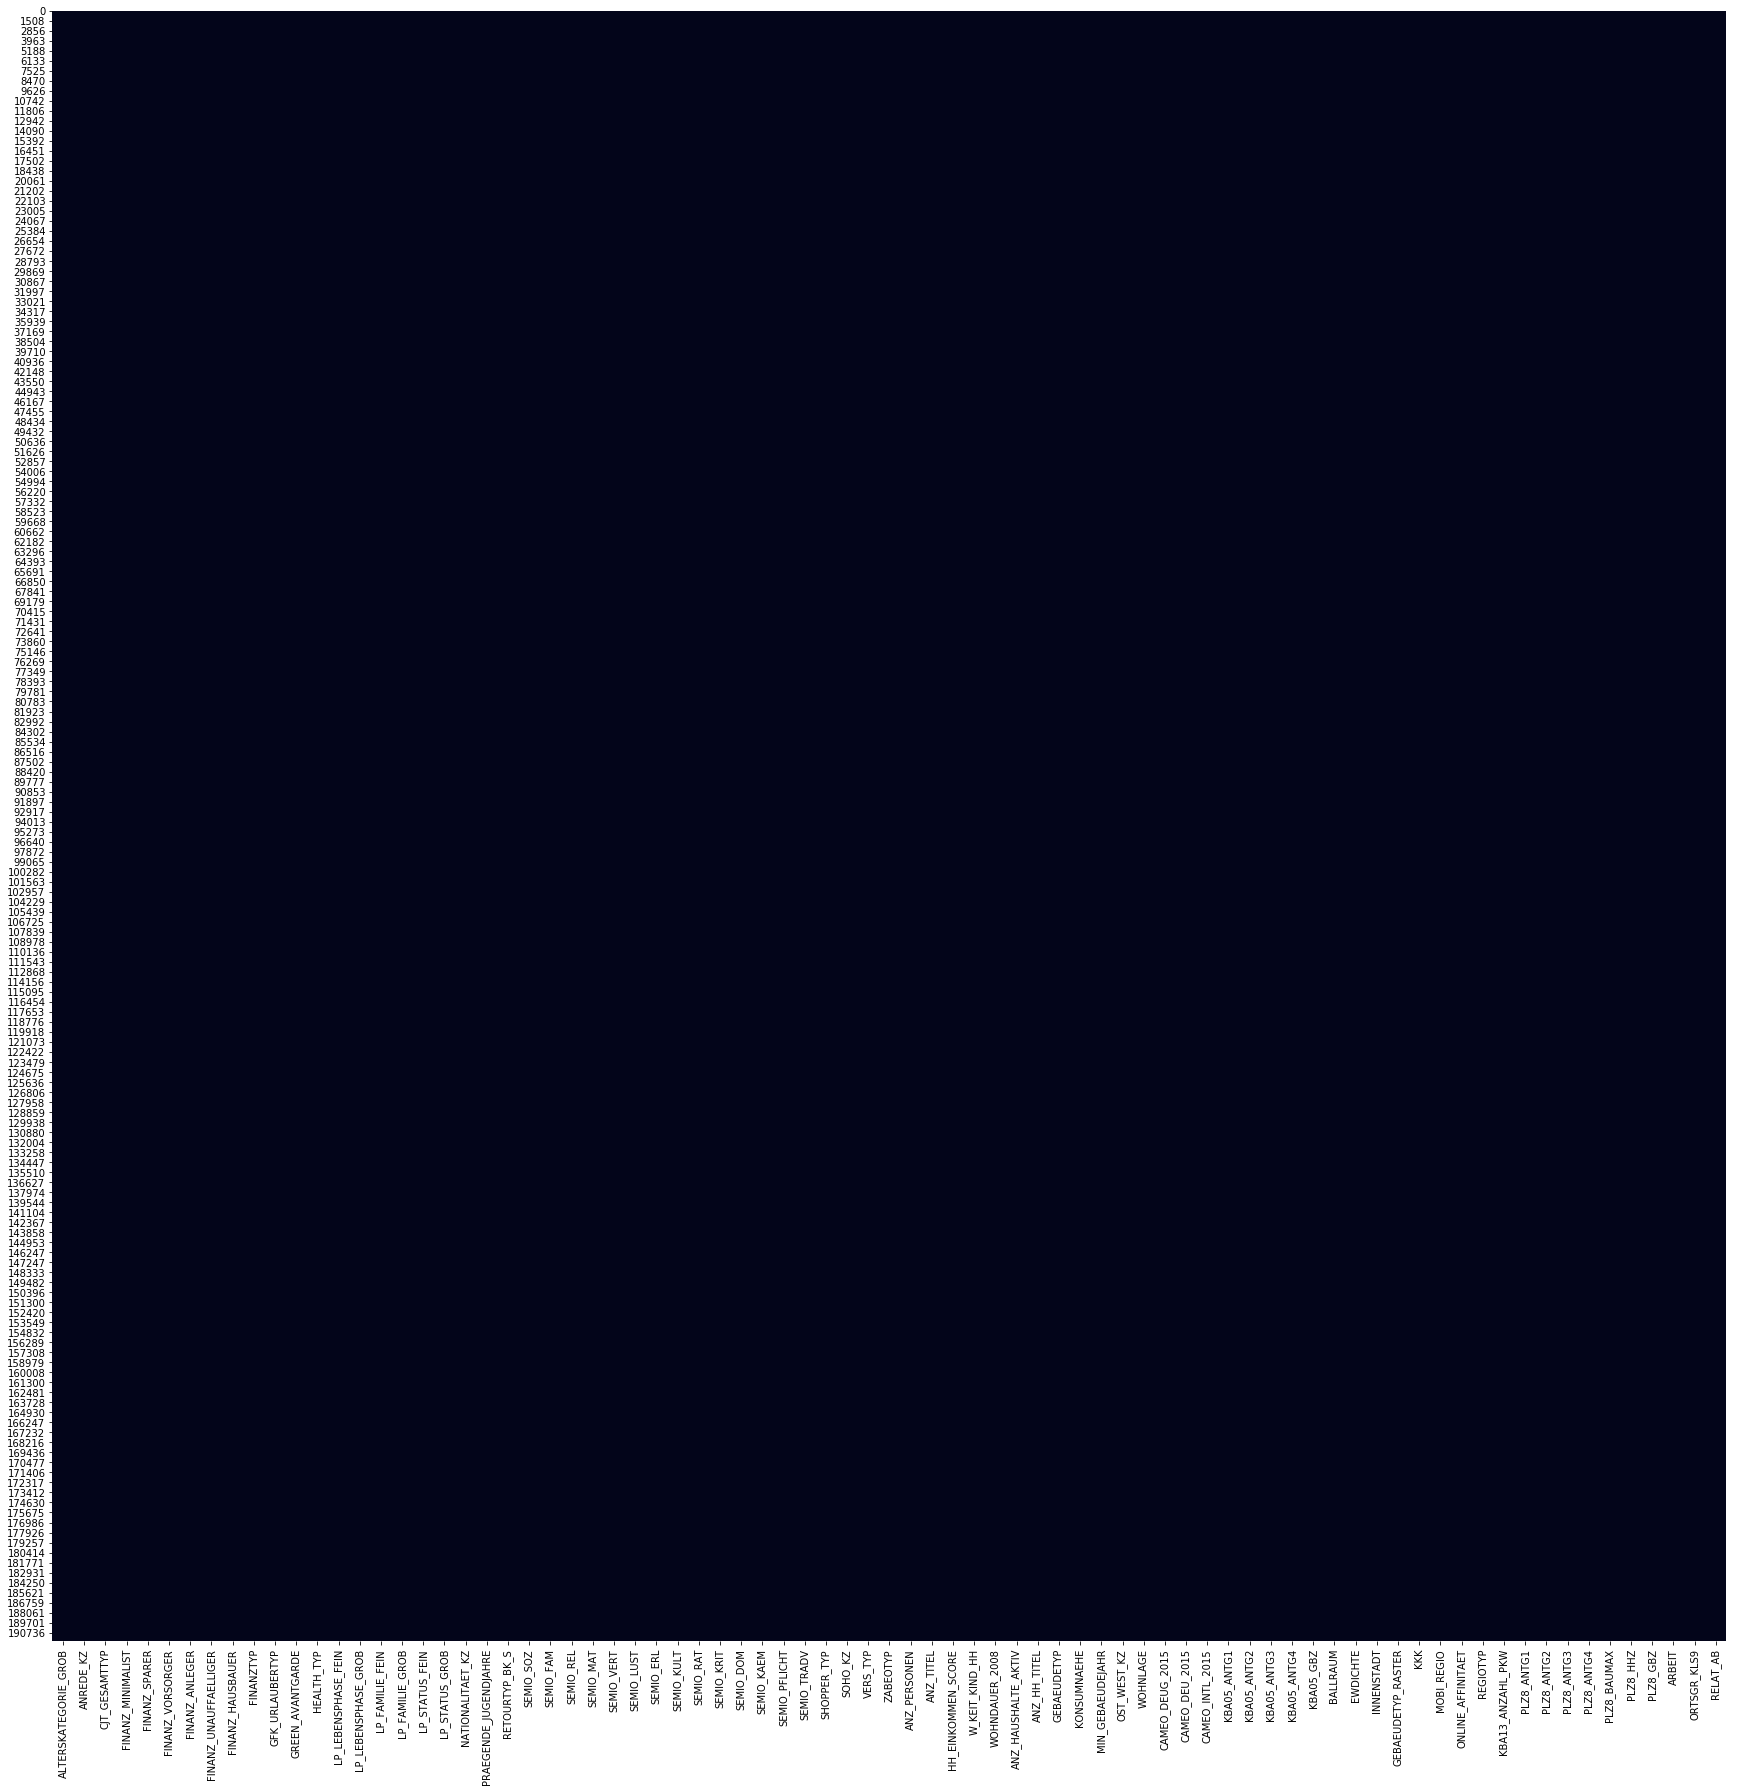

In [28]:
# Also, confirmed by the heatmap
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(custs1.isnull(), cbar=False, ax=ax)
plt.show()
plt.close()

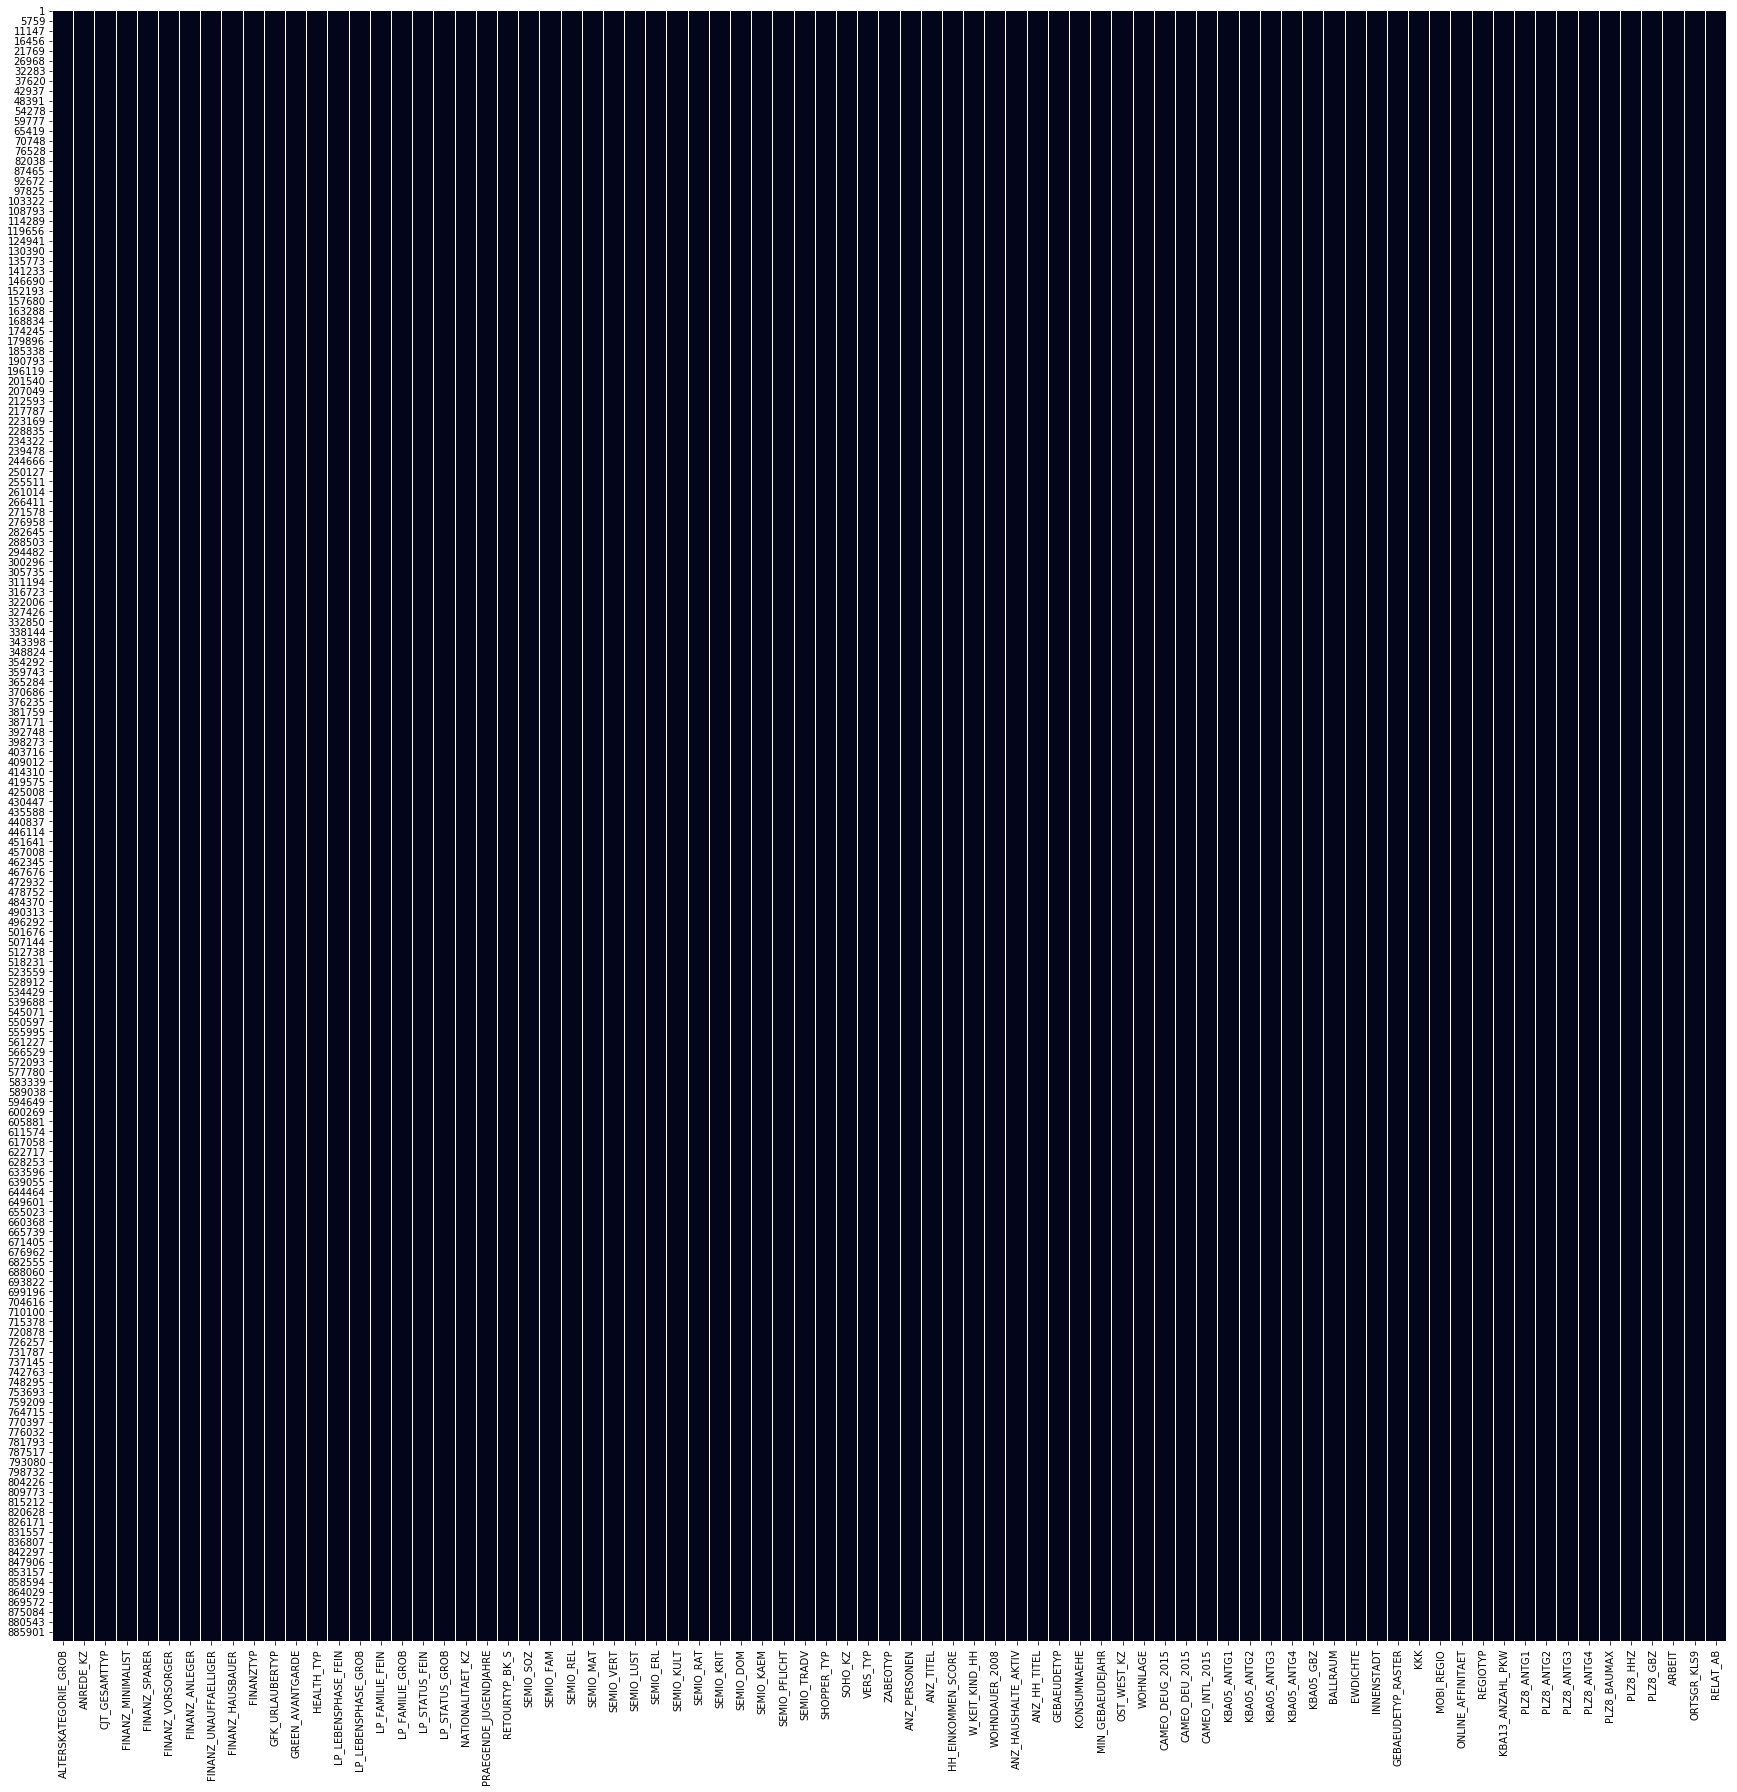

In [29]:
# Also, confirmed by the heatmap
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(azdias1.isnull(), cbar=False, ax=ax)
plt.show()
plt.close()

In [30]:
#Lets use a copy of azdias and custs where NaNs are removed for safety!
azdias1=azdias1.copy()
custs1=custs1.copy()

In [31]:
azdias1.to_csv('azdias1_working_copy.csv', sep=';')
custs1.to_csv('custs1_working_copy.csv', sep=';')

#### Discussion 1.1.3: Assess Missing Data in Each Row

As seen from the seaborn (coloured chart), we deduce that we have a concentration of row that lack data >32. They are also similar in what they lack as can be seen from the heatmap. In the heatmap, look especially at the pattern of white horizontal lines. Should one sort these out one could see complete white parts where data is missing in these row entries. 

Well, as we can see from the data above we have successfully dropped all NaNs with brute force. We do have all the datasets safe should we require them later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [114]:
#LOAD entry to enable quick resume if needed
azdias1 = pd.read_csv('azdias1_working_copy.csv', sep=';')
custs1 = pd.read_csv('custs1_working_copy.csv', sep=';')

In [115]:
#PVR 
azdias1.drop('Unnamed: 0', inplace=True, axis=1) #Only an effect of saving as a csv and loading again
custs1.drop('Unnamed: 0', inplace=True, axis=1)  #Only an effect of saving as a csv and loading again
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info.name="Feature info"

In [116]:
# How many features are there of each data type?
print('In the Feature Info file we can see the following statistics')
for i in ['categorical','mixed','ordinal','numeric']:
    print('{}: {} columns'.format(i, feat_info[feat_info['type']==i].shape[0]))

print("From the instruction above we do not touch ordinals, numerics.")
print("For ordinals, mixed and the very special kinds we investigate further below (if not dropped already)")

In the Feature Info file we can see the following statistics
categorical: 21 columns
mixed: 7 columns
ordinal: 49 columns
numeric: 7 columns
From the instruction above we do not touch ordinals, numerics.
For ordinals, mixed and the very special kinds we investigate further below (if not dropped already)


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [117]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
print('In the Feature Info file we can see the following statistics')
for i in ['categorical']:
    print('{}: {} columns with {} content'.format(i, feat_info[feat_info['type']==i].shape[0], feat_info[feat_info['type']==i]))


In the Feature Info file we can see the following statistics
categorical: 21 columns with            attribute information_level         type missing_or_unknown
0           AGER_TYP            person  categorical             [-1,0]
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical       

In [118]:
# Re-encode categorical variable(s) to be kept in the analysis.



In [119]:
'''
0           AGER_TYP - dropped already
2          ANREDE_KZ - just one hot encode
3      CJT_GESAMTTYP - just one hot encode
10         FINANZTYP - just one hot encode
12   GFK_URLAUBERTYP - just one hot encode
13  GREEN_AVANTGARDE - already coded
17   LP_FAMILIE_FEIN - dropped
18   LP_FAMILIE_GROB - just one hot encode
19    LP_STATUS_FEIN - dropped
20    LP_STATUS_GROB - just one hot encode. NOTE. 1 and 5 might overlap, but could also be german context playing in
21  NATIONALITAET_KZ - just one hot encode
38       SHOPPER_TYP - just one hot encode
39           SOHO_KZ - just one hot encode, might be irrelevant...
40          TITEL_KZ - dropped
41          VERS_TYP - just one hot encode
42          ZABEOTYP - just one hot encode. What does energy-"Smart" in Germany mean? And is "green" not smart? Coal?
47      KK_KUNDENTYP - dropped
52       GEBAEUDETYP - just one hot encode
55       OST_WEST_KZ - just one hot encode, but encode W as 0 and O as 1
57   CAMEO_DEUG_2015 - just one hot encode
58    CAMEO_DEU_2015 - dropped
'''

'\n0           AGER_TYP - dropped already\n2          ANREDE_KZ - just one hot encode\n3      CJT_GESAMTTYP - just one hot encode\n10         FINANZTYP - just one hot encode\n12   GFK_URLAUBERTYP - just one hot encode\n13  GREEN_AVANTGARDE - already coded\n17   LP_FAMILIE_FEIN - dropped\n18   LP_FAMILIE_GROB - just one hot encode\n19    LP_STATUS_FEIN - dropped\n20    LP_STATUS_GROB - just one hot encode. NOTE. 1 and 5 might overlap, but could also be german context playing in\n21  NATIONALITAET_KZ - just one hot encode\n38       SHOPPER_TYP - just one hot encode\n39           SOHO_KZ - just one hot encode, might be irrelevant...\n40          TITEL_KZ - dropped\n41          VERS_TYP - just one hot encode\n42          ZABEOTYP - just one hot encode. What does energy-"Smart" in Germany mean? And is "green" not smart? Coal?\n47      KK_KUNDENTYP - dropped\n52       GEBAEUDETYP - just one hot encode\n55       OST_WEST_KZ - just one hot encode, but encode W as 0 and O as 1\n57   CAMEO_DEUG_

In [120]:
# Re-encode OST_WEST_KZ, W->0, O->1 - we did that above already in part where we converted various NaNs into np.nan. 
#BUT here for remainder that one could do it here
azdias1['OST_WEST_KZ'].replace("W", 0, regex=True, inplace=True) 
azdias1['OST_WEST_KZ'].replace("O", 1, regex=True, inplace=True) 
custs1['OST_WEST_KZ'].replace("W", 0, regex=True, inplace=True) 
custs1['OST_WEST_KZ'].replace("O", 1, regex=True, inplace=True) 

In [121]:
#One hot encode categoricals
def myOneHotEncodeFunc1(df, feature, prefix_):
    return pd.concat([df, pd.get_dummies(df[feature], prefix = prefix_)], axis=1)

azdias1 = myOneHotEncodeFunc1(azdias1, 'ANREDE_KZ', 'ANREDE_KZ')
custs1 = myOneHotEncodeFunc1(custs1, 'ANREDE_KZ', 'ANREDE_KZ')

azdias1 = myOneHotEncodeFunc1(azdias1, 'CJT_GESAMTTYP', 'CJT_GESAMTTYP')
custs1 = myOneHotEncodeFunc1(custs1, 'CJT_GESAMTTYP', 'CJT_GESAMTTYP')

azdias1 = myOneHotEncodeFunc1(azdias1, 'FINANZTYP', 'FINANZTYP')
custs1 = myOneHotEncodeFunc1(custs1, 'FINANZTYP', 'FINANZTYP')

azdias1 = myOneHotEncodeFunc1(azdias1, 'GFK_URLAUBERTYP', 'GFK_URLAUBERTYP')
custs1 = myOneHotEncodeFunc1(custs1, 'GFK_URLAUBERTYP', 'GFK_URLAUBERTYP')

azdias1 = myOneHotEncodeFunc1(azdias1, 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB')
custs1 = myOneHotEncodeFunc1(custs1, 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB')

azdias1 = myOneHotEncodeFunc1(azdias1, 'LP_STATUS_GROB', 'LP_STATUS_GROB')
custs1 = myOneHotEncodeFunc1(custs1, 'LP_STATUS_GROB', 'LP_STATUS_GROB')

azdias1 = myOneHotEncodeFunc1(azdias1, 'NATIONALITAET_KZ', 'NATIONALITAET_KZ')
custs1 = myOneHotEncodeFunc1(custs1, 'NATIONALITAET_KZ', 'NATIONALITAET_KZ')

azdias1 = myOneHotEncodeFunc1(azdias1, 'SHOPPER_TYP', 'SHOPPER_TYP')
custs1 = myOneHotEncodeFunc1(custs1, 'SHOPPER_TYP', 'SHOPPER_TYP')

azdias1 = myOneHotEncodeFunc1(azdias1, 'SOHO_KZ', 'SOHO_KZ')
custs1 = myOneHotEncodeFunc1(custs1, 'SOHO_KZ', 'SOHO_KZ')

azdias1 = myOneHotEncodeFunc1(azdias1, 'VERS_TYP', 'VERS_TYP')
custs1 = myOneHotEncodeFunc1(custs1, 'VERS_TYP', 'VERS_TYP')

azdias1 = myOneHotEncodeFunc1(azdias1, 'ZABEOTYP', 'ZABEOTYP')
custs1 = myOneHotEncodeFunc1(custs1, 'ZABEOTYP', 'ZABEOTYP')

azdias1 = myOneHotEncodeFunc1(azdias1, 'GEBAEUDETYP', 'GEBAEUDETYP')
custs1 = myOneHotEncodeFunc1(custs1, 'GEBAEUDETYP', 'GEBAEUDETYP')

#azdias1 = myOneHotEncodeFunc1(azdias1, 'OST_WEST_KZ', 'OST_WEST_KZ')
#custs1 = myOneHotEncodeFunc1(custs1, 'OST_WEST_KZ', 'OST_WEST_KZ')

azdias1 = myOneHotEncodeFunc1(azdias1, 'CAMEO_DEUG_2015', 'CAMEO_DEUG_2015')
custs1 = myOneHotEncodeFunc1(custs1, 'CAMEO_DEUG_2015', 'CAMEO_DEUG_2015')

azdias1 = myOneHotEncodeFunc1(azdias1, 'LP_STATUS_FEIN', 'LP_STATUS_FEIN')
custs1 = myOneHotEncodeFunc1(custs1, 'LP_STATUS_FEIN', 'LP_STATUS_FEIN')
azdias1 = myOneHotEncodeFunc1(azdias1, 'LP_FAMILIE_FEIN', 'LP_FAMILIE_FEIN')
custs1 = myOneHotEncodeFunc1(custs1, 'LP_FAMILIE_FEIN', 'LP_FAMILIE_FEIN')
azdias1 = myOneHotEncodeFunc1(azdias1, 'CAMEO_DEU_2015', 'CAMEO_DEU_2015')
custs1 = myOneHotEncodeFunc1(custs1, 'CAMEO_DEU_2015', 'CAMEO_DEU_2015')


In [122]:
print(azdias1.columns.values)

['ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZ_MINIMALIST'
 'FINANZ_SPARER' 'FINANZ_VORSORGER' 'FINANZ_ANLEGER'
 'FINANZ_UNAUFFAELLIGER' 'FINANZ_HAUSBAUER' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'LP_LEBENSPHASE_FEIN'
 'LP_LEBENSPHASE_GROB' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB'
 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'NATIONALITAET_KZ'
 'PRAEGENDE_JUGENDJAHRE' 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL'
 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM'
 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'ANZ_PERSONEN' 'ANZ_TITEL' 'HH_EINKOMMEN_SCORE'
 'W_KEIT_KIND_HH' 'WOHNDAUER_2008' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL'
 'GEBAEUDETYP' 'KONSUMNAEHE' 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'WOHNLAGE'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' 'KBA05_ANTG1'
 'KBA05_ANTG2' 'KBA05_ANTG3' 'KBA05_ANTG4' 'KBA05_GBZ' 'BALLRAUM'
 'EWDICHTE' 'INNENSTADT' 'GEBAEUDET

In [123]:
#We make a mental note that some one hot encodings where not created as the neccessary 
#data where not present in the sample data set.
print("Missing one hot encodings in custs1: {}".format(azdias1.columns ^ custs1.columns))

Missing one hot encodings in custs1: Index(['GEBAEUDETYP_5.0'], dtype='object')


#### Discussion 1.2.1: Re-Encode Categorical Features

For the binary (two-level) categoricals that take numeric values, we kept them as they where. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [124]:
# We look at the MIXED column data below
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
print('In the Feature Info file we can see the following statistics')
for i in ['mixed']:
    print('{}: {} columns with {} content'.format(i, feat_info[feat_info['type']==i].shape[0], feat_info[feat_info['type']==i]))


In the Feature Info file we can see the following statistics
mixed: 7 columns with                 attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0] content


In [125]:
'''
15    LP_LEBENSPHASE_FEIN - just one hot encode
16    LP_LEBENSPHASE_GROB - just one hot encode
22  PRAEGENDE_JUGENDJAHRE - treat special
56               WOHNLAGE - could be two attibutes in one, but as we one hot encode this it does not matter.
                            The Germans think that rural is worse/bettter than living in poor neigbourhoods 
                            as you cannot have both set at the same time. 
                            Note: Lost data is lost and cannot be retrieved here
59        CAMEO_INTL_2015 - treat special, needs to be split in two categories?
64           KBA05_BAUMAX - dropped 
79            PLZ8_BAUMAX - could be two attibutes in one, but as we one hot encode this it does not matter.
                            The Germans have argued perhaps that you cannot have more than one category of 
                            main buildings. As business buildings are not further classified they are kept in one large 
                            label, but family homes are more granlar. However, again you cannot have both 
                            business and family houses set in this category, thus mutually excluding each other, 
                            making one hot encoding perfectly fine. 
                            Note: Lost data is lost and cannot be retrieved here
'''

'\n15    LP_LEBENSPHASE_FEIN - just one hot encode\n16    LP_LEBENSPHASE_GROB - just one hot encode\n22  PRAEGENDE_JUGENDJAHRE - treat special\n56               WOHNLAGE - could be two attibutes in one, but as we one hot encode this it does not matter.\n                            The Germans think that rural is worse/bettter than living in poor neigbourhoods \n                            as you cannot have both set at the same time. \n                            Note: Lost data is lost and cannot be retrieved here\n59        CAMEO_INTL_2015 - treat special, needs to be split in two categories?\n64           KBA05_BAUMAX - dropped \n79            PLZ8_BAUMAX - could be two attibutes in one, but as we one hot encode this it does not matter.\n                            The Germans have argued perhaps that you cannot have more than one category of \n                            main buildings. As business buildings are not further classified they are kept in one large \n                  

In [126]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables - Decade, Movement. 
# We drop West, East info that are incomplete in the data
def pj_wrangling(number):
    if (math.isnan(number)):
        return np.nan, np.nan
    if (number==1):
        return 1940,'Mainstream'
    if (number==2):
        return 1940,'Avantgarde'
    if (number==3):
        return 1950,'Mainstream'
    if (number==4):
        return 1950,'Avantgarde'
    if (number==5):
        return 1960,'Mainstream'
    if (number==6):
        return 1960,'Avantgarde' # Note similar to 7
    if (number==7):
        return 1960,'Avantgarde'
    if (number==8):
        return 1970,'Mainstream'
    if (number==9):
        return 1970,'Avantgarde'
    if (number==10):
        return 1980,'Mainstream' # Note similar to 12
    if (number==11):
        return 1980,'Avantgarde' # Note similar to 13
    if (number==12):
        return 1980,'Mainstream'
    if (number==13):
        return 1980,'Avantgarde'
    if (number==14):
        return 1990,'Mainstream'
    if (number==15):
        return 1990,'Avantgarde'
    return np.nan, np.nan

azdias1['DECADE'], azdias1['MOVEMENT'] = zip(*azdias1['PRAEGENDE_JUGENDJAHRE'].map(pj_wrangling))
custs1['DECADE'], custs1['MOVEMENT'] = zip(*custs1['PRAEGENDE_JUGENDJAHRE'].map(pj_wrangling))
azdias1['DECADE']=azdias1['DECADE'].astype(int)
custs1['DECADE']=custs1['DECADE'].astype(int)
print(azdias1['PRAEGENDE_JUGENDJAHRE'].head(5))
print(azdias1['DECADE'].head(5))
print(azdias1['MOVEMENT'].head(5))

    

0    14.0
1    15.0
2     8.0
3     3.0
4    10.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
0    1990
1    1990
2    1970
3    1950
4    1980
Name: DECADE, dtype: int64
0    Mainstream
1    Avantgarde
2    Mainstream
3    Mainstream
4    Mainstream
Name: MOVEMENT, dtype: object


In [127]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Split column entry XY into column X and column Y. 
# Eg. 
# 51: Poorer Households - Pre-Family Couples & Singles -> 5: Poorer Households, 1: Pre-Family Couples & Singles
# 52: Poorer Households - Young Couples With Children -> 5: Poorer Households, 2: Young Couples With Children
# use "l, r = str[:1], str[1:]"

# NEW MARKDOWN - 
# CAMEO_INTL_2015_L - 1: 'Wealthy Households',
#                     2: 'Prosperous Households',
#                     3: 'Comfortable Households',
#                     4: 'Less Affluent Households',
#                     5: 'Poorer Households'
#
# CAMEO_INTL_2015_R - 1: 'Pre-Family Couples & Singles'
#                     2: 'Young Couples With Children'
#                     3: 'Families With School Age Children'
#                     4: 'Older Families & Mature Couples'
#                     5: 'Elders In Retirement'


def switch(number):
    if isinstance(number, str):
        temp=str(int(number))
        #print(temp)
    elif (math.isnan(number)):
        return np.nan, np.nan
    else:
        temp=str(int(number))

    return temp[:1], temp[1:]

azdias1['CAMEO_INTL_2015_L'], azdias1['CAMEO_INTL_2015_R'] = zip(*azdias1['CAMEO_INTL_2015'].map(switch))
custs1['CAMEO_INTL_2015_L'], custs1['CAMEO_INTL_2015_R'] = zip(*custs1['CAMEO_INTL_2015'].map(switch))
#testing
print(azdias1['CAMEO_INTL_2015'].head(5))
print(azdias1['CAMEO_INTL_2015_L'].head(5))
print(azdias1['CAMEO_INTL_2015_R'].head(5))

0    51
1    24
2    43
3    54
4    22
Name: CAMEO_INTL_2015, dtype: int64
0    5
1    2
2    4
3    5
4    2
Name: CAMEO_INTL_2015_L, dtype: object
0    1
1    4
2    3
3    4
4    2
Name: CAMEO_INTL_2015_R, dtype: object


In [128]:
#Lets One hot encode the resulting columns
#LP_LEBENSPHASE_GROB
azdias1 = myOneHotEncodeFunc1(azdias1, 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_GROB')
custs1 = myOneHotEncodeFunc1(custs1, 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_GROB')

#DECADE
azdias1 = myOneHotEncodeFunc1(azdias1, 'DECADE', 'DECADE')
custs1 = myOneHotEncodeFunc1(custs1, 'DECADE', 'DECADE')

#MOVEMENT
azdias1 = myOneHotEncodeFunc1(azdias1, 'MOVEMENT', 'MOVEMENT')
custs1 = myOneHotEncodeFunc1(custs1, 'MOVEMENT', 'MOVEMENT')

#WOHNLAGE
azdias1 = myOneHotEncodeFunc1(azdias1, 'WOHNLAGE', 'WOHNLAGE')
custs1 = myOneHotEncodeFunc1(custs1, 'WOHNLAGE', 'WOHNLAGE')

#PLZ8_BAUMAX
azdias1 = myOneHotEncodeFunc1(azdias1, 'PLZ8_BAUMAX', 'PLZ8_BAUMAX')
custs1 = myOneHotEncodeFunc1(custs1, 'PLZ8_BAUMAX', 'PLZ8_BAUMAX')

#CAMEO_INTL_2015_L
azdias1 = myOneHotEncodeFunc1(azdias1, 'CAMEO_INTL_2015_L', 'CAMEO_INTL_2015_L')
custs1 = myOneHotEncodeFunc1(custs1, 'CAMEO_INTL_2015_L', 'CAMEO_INTL_2015_L')

#CAMEO_INTL_2015_R
azdias1 = myOneHotEncodeFunc1(azdias1, 'CAMEO_INTL_2015_R', 'CAMEO_INTL_2015_R')
custs1 = myOneHotEncodeFunc1(custs1, 'CAMEO_INTL_2015_R', 'CAMEO_INTL_2015_R')

#LP_LEBENSPHASE_FEIN
azdias1 = myOneHotEncodeFunc1(azdias1, 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN')
custs1 = myOneHotEncodeFunc1(custs1, 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN')



#### Discussion 1.2.2: Engineer Mixed-Type Features

We reengineered CAMEO_INTL_2015 as described above. This was necessary due to one variable contained the answer to two questions. This is a response to a "bad" database schema. Similar we split up the PRAEGENDE_JUGENDJAHRE into 2 new categoricals (it should have been 3 but the data granularity was not enough). The rest was untouched into the one hot encoding following the discussion above 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [129]:
temp1=azdias1.isnull().sum().sum()
print('azdias1 - No NaN/NULLs: {}'.format(temp1))
temp2=azdias1.isnull().T.any().T.sum()
print("azdias1 - No Rows with NaN/NULL: {}".format(temp2))

azdias1 - No NaN/NULLs: 0
azdias1 - No Rows with NaN/NULL: 0


In [130]:
temp1=custs1.isnull().sum().sum()
print('custs1 - No NaN/NULLs: {}'.format(temp1))
temp2=custs1.isnull().T.any().T.sum()
print("custs1 - No Rows with NaN/NULL: {}".format(temp2))

custs1 - No NaN/NULLs: 0
custs1 - No Rows with NaN/NULL: 0


In [131]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print(custs1.columns.values)


['ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZ_MINIMALIST'
 'FINANZ_SPARER' 'FINANZ_VORSORGER' 'FINANZ_ANLEGER'
 'FINANZ_UNAUFFAELLIGER' 'FINANZ_HAUSBAUER' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'LP_LEBENSPHASE_FEIN'
 'LP_LEBENSPHASE_GROB' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB'
 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'NATIONALITAET_KZ'
 'PRAEGENDE_JUGENDJAHRE' 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL'
 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM'
 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'ANZ_PERSONEN' 'ANZ_TITEL' 'HH_EINKOMMEN_SCORE'
 'W_KEIT_KIND_HH' 'WOHNDAUER_2008' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL'
 'GEBAEUDETYP' 'KONSUMNAEHE' 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'WOHNLAGE'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' 'KBA05_ANTG1'
 'KBA05_ANTG2' 'KBA05_ANTG3' 'KBA05_ANTG4' 'KBA05_GBZ' 'BALLRAUM'
 'EWDICHTE' 'INNENSTADT' 'GEBAEUDET

In [132]:
# We drop columns we have already one hot encoded. Why we do this here is that we do not want to 
# spread out the deletion of information all over the code base

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias1.drop('ANREDE_KZ', inplace=True, axis=1) 
azdias1.drop('CJT_GESAMTTYP', inplace=True, axis=1) 
azdias1.drop('FINANZTYP', inplace=True, axis=1) 
azdias1.drop('GFK_URLAUBERTYP', inplace=True, axis=1) 
azdias1.drop('LP_FAMILIE_GROB', inplace=True, axis=1) 
azdias1.drop('LP_STATUS_GROB', inplace=True, axis=1) 
azdias1.drop('NATIONALITAET_KZ', inplace=True, axis=1) 
azdias1.drop('SHOPPER_TYP', inplace=True, axis=1) 
azdias1.drop('SOHO_KZ', inplace=True, axis=1) 
azdias1.drop('VERS_TYP', inplace=True, axis=1) 
azdias1.drop('ZABEOTYP', inplace=True, axis=1) 
azdias1.drop('GEBAEUDETYP', inplace=True, axis=1) 
azdias1.drop('OST_WEST_KZ', inplace=True, axis=1) 
azdias1.drop('CAMEO_DEUG_2015', inplace=True, axis=1) 
azdias1.drop('PRAEGENDE_JUGENDJAHRE', inplace=True, axis=1) 
azdias1.drop('DECADE', inplace=True, axis=1) 
azdias1.drop('MOVEMENT', inplace=True, axis=1) 
azdias1.drop('CAMEO_INTL_2015', inplace=True, axis=1) 
azdias1.drop('CAMEO_INTL_2015_L', inplace=True, axis=1) 
azdias1.drop('CAMEO_INTL_2015_R', inplace=True, axis=1) 
azdias1.drop('LP_STATUS_FEIN', inplace=True, axis=1) 
azdias1.drop('LP_FAMILIE_FEIN', inplace=True, axis=1) 
azdias1.drop('CAMEO_DEU_2015', inplace=True, axis=1) 
azdias1.drop('LP_LEBENSPHASE_FEIN', inplace=True, axis=1) 
azdias1.drop('LP_LEBENSPHASE_GROB', inplace=True, axis=1) 
azdias1.drop('PLZ8_BAUMAX', inplace=True, axis=1) 
azdias1.drop('WOHNLAGE', inplace=True, axis=1) 

custs1.drop('ANREDE_KZ', inplace=True, axis=1) 
custs1.drop('CJT_GESAMTTYP', inplace=True, axis=1) 
custs1.drop('FINANZTYP', inplace=True, axis=1) 
custs1.drop('GFK_URLAUBERTYP', inplace=True, axis=1) 
custs1.drop('LP_FAMILIE_GROB', inplace=True, axis=1) 
custs1.drop('LP_STATUS_GROB', inplace=True, axis=1) 
custs1.drop('NATIONALITAET_KZ', inplace=True, axis=1) 
custs1.drop('SHOPPER_TYP', inplace=True, axis=1) 
custs1.drop('SOHO_KZ', inplace=True, axis=1) 
custs1.drop('VERS_TYP', inplace=True, axis=1) 
custs1.drop('ZABEOTYP', inplace=True, axis=1) 
custs1.drop('GEBAEUDETYP', inplace=True, axis=1) 
custs1.drop('OST_WEST_KZ', inplace=True, axis=1) 
custs1.drop('CAMEO_DEUG_2015', inplace=True, axis=1) 
custs1.drop('PRAEGENDE_JUGENDJAHRE', inplace=True, axis=1) 
custs1.drop('DECADE', inplace=True, axis=1) 
custs1.drop('MOVEMENT', inplace=True, axis=1) 
custs1.drop('CAMEO_INTL_2015', inplace=True, axis=1) 
custs1.drop('CAMEO_INTL_2015_L', inplace=True, axis=1) 
custs1.drop('CAMEO_INTL_2015_R', inplace=True, axis=1) 
custs1.drop('LP_STATUS_FEIN', inplace=True, axis=1) 
custs1.drop('LP_FAMILIE_FEIN', inplace=True, axis=1) 
custs1.drop('CAMEO_DEU_2015', inplace=True, axis=1) 
custs1.drop('LP_LEBENSPHASE_FEIN', inplace=True, axis=1) 
custs1.drop('LP_LEBENSPHASE_GROB', inplace=True, axis=1) 
custs1.drop('PLZ8_BAUMAX', inplace=True, axis=1) 
custs1.drop('WOHNLAGE', inplace=True, axis=1) 

In [133]:
#Still we note the missing column originating from the sample not containing the example (from the one hot encoding)
print("Missing one hot encodings in custs1: {}".format(azdias1.columns ^ custs1.columns))

Missing one hot encodings in custs1: Index(['GEBAEUDETYP_5.0', 'WOHNLAGE_0.0'], dtype='object')


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [134]:
def myOneHotEncodeFunc2(df, feature, prefix_):
    return pd.concat([df, pd.get_dummies(df[feature], prefix = prefix_)], axis=1)

def pj_wrangling2(number):
    if (math.isnan(number)):
        return np.nan, np.nan
    if (number==1):
        return 1940,'Mainstream'
    if (number==2):
        return 1940,'Avantgarde'
    if (number==3):
        return 1950,'Mainstream'
    if (number==4):
        return 1950,'Avantgarde'
    if (number==5):
        return 1960,'Mainstream'
    if (number==6):
        return 1960,'Avantgarde' # Note similar to 7
    if (number==7):
        return 1960,'Avantgarde'
    if (number==8):
        return 1970,'Mainstream'
    if (number==9):
        return 1970,'Avantgarde'
    if (number==10):
        return 1980,'Mainstream' # Note similar to 12
    if (number==11):
        return 1980,'Avantgarde' # Note similar to 13
    if (number==12):
        return 1980,'Mainstream'
    if (number==13):
        return 1980,'Avantgarde'
    if (number==14):
        return 1990,'Mainstream'
    if (number==15):
        return 1990,'Avantgarde'
    return np.nan, np.nan

def switch2(number):
    if isinstance(number, str):
        temp=str(int(number))
        pass
    elif (math.isnan(number)):
        return np.nan, np.nan
    else:
        temp=str(int(number))

    return temp[:1], temp[1:]


def clean_data(df, thresh_=75):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:  Demographics DataFrame
            Threashold for dropping NaN-containing rows, defaults to 75, i.e. all dropped where NaN is present
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info.name="Feature info"

    df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
    df.name="Customers"

    for i,j in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
        if (i == 'CAMEO_DEU_2015' or i=='CAMEO_DEUG_2015' or i=='CAMEO_INTL_2015' or i == 'OST_WEST_KZ'):
            pass
        else:
            k = literal_eval(j)
            for l in k:
                df[i].replace(l,-1, regex=True, inplace=True) 

    df.replace(-1,np.nan, regex=True, inplace=True) 
    df.replace('-1',np.nan, regex=True, inplace=True) 
    df['OST_WEST_KZ'].replace("W", 0, regex=True, inplace=True) 
    df['OST_WEST_KZ'].replace("O", 1, regex=True, inplace=True)
    df.replace('X',np.nan, regex=True, inplace=True) 
    df.replace('XX',np.nan, regex=True, inplace=True) 
    df.drop('AGER_TYP', inplace=True, axis=1)
    df.drop('GEBURTSJAHR', inplace=True, axis=1) 
    df.drop('TITEL_KZ', inplace=True, axis=1)
    df.drop('ALTER_HH', inplace=True, axis=1) 
    df.drop('KK_KUNDENTYP', inplace=True, axis=1)
    df.drop('KBA05_BAUMAX', inplace=True, axis=1)
    df = df.dropna(thresh=thresh_) #drop all rows with NaNs

    df = myOneHotEncodeFunc2(df, 'ANREDE_KZ', 'ANREDE_KZ')
    df = myOneHotEncodeFunc2(df, 'CJT_GESAMTTYP', 'CJT_GESAMTTYP')
    df = myOneHotEncodeFunc2(df, 'FINANZTYP', 'FINANZTYP')
    df = myOneHotEncodeFunc2(df, 'GFK_URLAUBERTYP', 'GFK_URLAUBERTYP')
    df = myOneHotEncodeFunc2(df, 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB')
    df = myOneHotEncodeFunc2(df, 'LP_STATUS_GROB', 'LP_STATUS_GROB')
    df = myOneHotEncodeFunc2(df, 'NATIONALITAET_KZ', 'NATIONALITAET_KZ')
    df = myOneHotEncodeFunc2(df, 'SHOPPER_TYP', 'SHOPPER_TYP')
    df = myOneHotEncodeFunc2(df, 'SOHO_KZ', 'SOHO_KZ')
    df = myOneHotEncodeFunc2(df, 'VERS_TYP', 'VERS_TYP')
    df = myOneHotEncodeFunc2(df, 'ZABEOTYP', 'ZABEOTYP')
    df = myOneHotEncodeFunc2(df, 'GEBAEUDETYP', 'GEBAEUDETYP')
#    df = myOneHotEncodeFunc2(df, 'OST_WEST_KZ', 'OST_WEST_KZ')
    df = myOneHotEncodeFunc2(df, 'CAMEO_DEUG_2015', 'CAMEO_DEUG_2015')
    df = myOneHotEncodeFunc2(df, 'LP_STATUS_FEIN', 'LP_STATUS_FEIN')
    df = myOneHotEncodeFunc2(df, 'LP_FAMILIE_FEIN', 'LP_FAMILIE_FEIN')
    df = myOneHotEncodeFunc2(df, 'CAMEO_DEU_2015', 'CAMEO_DEU_2015')
    df = myOneHotEncodeFunc2(df, 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN')
    
    df['DECADE'], df['MOVEMENT'] = zip(*df['PRAEGENDE_JUGENDJAHRE'].map(pj_wrangling2))
    df['DECADE'] = df['DECADE'].astype(int)

    df['CAMEO_INTL_2015_L'], df['CAMEO_INTL_2015_R'] = zip(*df['CAMEO_INTL_2015'].map(switch2))
    df = myOneHotEncodeFunc2(df, 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_GROB')
    df = myOneHotEncodeFunc2(df, 'DECADE', 'DECADE')
    df = myOneHotEncodeFunc2(df, 'MOVEMENT', 'MOVEMENT')
    df = myOneHotEncodeFunc2(df, 'WOHNLAGE', 'WOHNLAGE')
    df = myOneHotEncodeFunc2(df, 'PLZ8_BAUMAX', 'PLZ8_BAUMAX')
    df = myOneHotEncodeFunc2(df, 'CAMEO_INTL_2015_L', 'CAMEO_INTL_2015_L')
    df = myOneHotEncodeFunc2(df, 'CAMEO_INTL_2015_R', 'CAMEO_INTL_2015_R')
    df.drop('ANREDE_KZ', inplace=True, axis=1) 
    df.drop('CJT_GESAMTTYP', inplace=True, axis=1) 
    df.drop('FINANZTYP', inplace=True, axis=1) 
    df.drop('GFK_URLAUBERTYP', inplace=True, axis=1) 
    df.drop('LP_FAMILIE_GROB', inplace=True, axis=1) 
    df.drop('LP_STATUS_GROB', inplace=True, axis=1) 
    df.drop('NATIONALITAET_KZ', inplace=True, axis=1) 
    df.drop('SHOPPER_TYP', inplace=True, axis=1) 
    df.drop('SOHO_KZ', inplace=True, axis=1) 
    df.drop('VERS_TYP', inplace=True, axis=1) 
    df.drop('ZABEOTYP', inplace=True, axis=1) 
    df.drop('GEBAEUDETYP', inplace=True, axis=1) 
    df.drop('OST_WEST_KZ', inplace=True, axis=1) 
    df.drop('CAMEO_DEUG_2015', inplace=True, axis=1) 
    df.drop('PRAEGENDE_JUGENDJAHRE', inplace=True, axis=1) 
    df.drop('DECADE', inplace=True, axis=1) 
    df.drop('MOVEMENT', inplace=True, axis=1) 
    df.drop('CAMEO_INTL_2015', inplace=True, axis=1) 
    df.drop('CAMEO_INTL_2015_L', inplace=True, axis=1) 
    df.drop('CAMEO_INTL_2015_R', inplace=True, axis=1)
    df.drop('LP_STATUS_FEIN', inplace=True, axis=1) 
    df.drop('LP_FAMILIE_FEIN', inplace=True, axis=1) 
    df.drop('CAMEO_DEU_2015', inplace=True, axis=1) 
    df.drop('LP_LEBENSPHASE_FEIN', inplace=True, axis=1) 
    df.drop('LP_LEBENSPHASE_GROB', inplace=True, axis=1) 
    df.drop('PLZ8_BAUMAX', inplace=True, axis=1) 
    df.drop('WOHNLAGE', inplace=True, axis=1) 
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [135]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
'''1. Impute or drop NaN-rows now'''

print("Missing one hot encodings in custs1: {}".format(azdias1.columns ^ custs1.columns))

Missing one hot encodings in custs1: Index(['GEBAEUDETYP_5.0', 'WOHNLAGE_0.0'], dtype='object')


In [136]:
#Lets add these ONE HOT ENCODING columns filled with zero
custs1, azdias1 = custs1.align(azdias1, axis=1, fill_value=0)
custs1_sc, azdias1_sc = custs1.align(azdias1, axis=1, fill_value=0)

In [137]:
# Apply feature scaling to the general population demographics data.
# Code below for scaling to ~N(0,1)
# We refer to the article below for a discussion about WHY it is so important to scale the data
# https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e
# PvR
scaler = preprocessing.StandardScaler()
azdias1_sc = scaler.fit_transform(azdias1)
custs1_sc = scaler.transform(custs1)


/smalltank/udacity/miniconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/smalltank/udacity/miniconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/smalltank/udacity/miniconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


### Discussion 2.1: Apply Feature Scaling

In this assignment I did drop all rows not containing all data. However the oppurtunity is there to address the leftovers should one wish that. I did apply StandardScaler as prescribed in this intro above. Ref: https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
custs1.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ_1', 'ANREDE_KZ_2',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2',
       'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5',
       'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8',
       'CAMEO_DEUG_2015_9', 'CAMEO_DEU_2015_1A', 'CAMEO_DEU_2015_1B',
       'CAMEO_DEU_2015_1C', 'CAMEO_DEU_2015_1D', 'CAMEO_DEU_2015_1E',
       'CAMEO_DEU_2015_2A', 'CAMEO_DEU_2015_2B', 'CAMEO_DEU_2015_2C',
       'CAMEO_DEU_2015_2D', 'CAMEO_DEU_2015_3A', 'CAMEO_DEU_2015_3B',
       'CAMEO_DEU_2015_3C', 'CAMEO_DEU_2015_3D', 'CAMEO_DEU_2015_4A',
       'CAMEO_DEU_2015_4B', 'CAMEO_DEU_2015_4C', 'CAMEO_DEU_2015_4D',
       'CAMEO_DEU_2015_4E', 'CAMEO_DEU_2015_5A', 'CAMEO_DEU_2015_5B',
       'CAMEO_DEU_2015_5C', 'CAMEO_DEU_2015_5D', 'CAMEO_DEU_2015_5E',
       'CAMEO_DEU_2015_5F', 'CAMEO_DEU_2015_6A', 'CAMEO_DEU_2015_6B',
       'CAMEO_DEU_2015_

In [138]:
print(custs1.shape)
print(azdias1.shape)
print("Missing one hot encodings in custs1: {}".format(azdias1.columns ^ custs1.columns))

(115643, 270)
(623209, 270)
Missing one hot encodings in custs1: Index([], dtype='object')


In [139]:
# Apply PCA to the data.
pca_azdias1 = PCA(n_components=len(azdias1.columns)).fit(azdias1_sc)

pca_azdias1_transformed = pca_azdias1.transform(azdias1_sc) # Apply PCA on population i.e. AZDIAS


KeyboardInterrupt: 

In [ ]:
# Investigate the variance accounted for by each principal component.
def investigate_pca(pca):
    explained_var=pca.explained_variance_ratio_

    explained_var2=sum([explained_var[i] for i in range(2)])
    explained_var5=sum([explained_var[i] for i in range(5)])
    explained_var10=sum([explained_var[i] for i in range(10)])
    explained_var20=sum([explained_var[i] for i in range(20)])
    print ('Total Variance from first 2 components:',explained_var2)
    print ('Total Variance from first 5 components:',explained_var5)
    print ('Total Variance from first 10 components:',explained_var10)
    print ('Total Variance from first 20 components:',explained_var20)
    return explained_var

print("PCA results")
explained_var = investigate_pca(pca_azdias1)


Text(0, 0.5, 'Cumulative Variance explained')

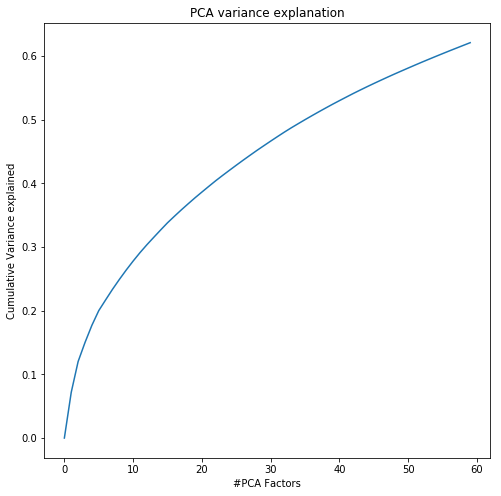

In [54]:
cumPCAexpl=[]
for j in range(60):
    cumPCAexpl.append(sum([explained_var[i] for i in range(j)]))
fig = plt.figure(figsize = (8,8))
plt.plot(cumPCAexpl)
plt.title('PCA variance explanation')
plt.xlabel('#PCA Factors')
plt.ylabel('Cumulative Variance explained')

In [140]:
# Re-apply PCA to the data while selecting for number of components to retain.
# I selected 20 as I am only interested (at this moment) to describe the distinct and thus relevant data. 
# We are not interested to discuss small data details in the population (perhaps we need to revise this later)
num_pca=20
pca_azdias_final = PCA(n_components=num_pca).fit(azdias1_sc)

pca_azdias1_transformed = pca_azdias_final.transform(azdias1_sc)# Apply PCA on population i.e. AZDIAS
pca_custs1_transformed = pca_azdias_final.transform(custs1_sc)# Apply PCA on sample i.e. customers


In [141]:
explained_var=pca_azdias_final.explained_variance_ratio_

In [142]:
my_index=[]
for i in range(num_pca):
    my_index.append('PC'+str(i))

In [143]:
my_azdias_weights=pd.DataFrame(pca_azdias_final.components_,columns=azdias1.columns,index =my_index)
my_azdias_weights_2 = my_azdias_weights.T.copy()

In [144]:
print("PC1 explanatory power: {:.3f}%".format(100*explained_var[0]))
print(my_azdias_weights_2.sort_values(by='PC1', ascending=False).index[0:5])
print(my_azdias_weights_2.sort_values(by='PC1', ascending=True).index[0:5])
print("PC2 explanatory power: {:.3f}%".format(100*explained_var[1]))
print(my_azdias_weights_2.sort_values(by='PC2', ascending=False).index[0:5])
print(my_azdias_weights_2.sort_values(by='PC2', ascending=True).index[0:5])
print("PC3 explanatory power: {:.3f}%".format(100*explained_var[2]))
print(my_azdias_weights_2.sort_values(by='PC3', ascending=False).index[0:5])
print(my_azdias_weights_2.sort_values(by='PC3', ascending=True).index[0:5])
print("PC4 explanatory power: {:.3f}%".format(100*explained_var[3]))
print("PC5 explanatory power: {:.3f}%".format(100*explained_var[4]))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(my_azdias_weights_2[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

PC1 explanatory power: 7.001%
Index(['ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'ZABEOTYP_3', 'SEMIO_ERL', 'RETOURTYP_BK_S'], dtype='object')
Index(['FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_REL', 'SEMIO_PFLICHT', 'DECADE_1990'], dtype='object')
PC2 explanatory power: 4.883%
Index(['ANREDE_KZ_1', 'SEMIO_VERT', 'SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_KULT'], dtype='object')
Index(['ANREDE_KZ_2', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_ERL'], dtype='object')
PC3 explanatory power: 3.009%
Index(['MOVEMENT_Avantgarde', 'GREEN_AVANTGARDE', 'LP_STATUS_GROB_5.0', 'LP_STATUS_FEIN_10.0',
       'ORTSGR_KLS9'],
      dtype='object')
Index(['MOVEMENT_Mainstream', 'LP_STATUS_GROB_4.0', 'LP_STATUS_FEIN_9.0', 'LP_FAMILIE_GROB_1.0',
       'LP_FAMILIE_FEIN_1.0'],
      dtype='object')
PC4 explanatory power: 2.587%
PC5 explanatory power: 2.158%
                               PC1       PC2       PC3       PC4       PC5
ALTERSKATEGORIE_GROB      0.214264  0.007596 -0.012685  0.040845 -0.017746


In [145]:
custs1.head(5).T

,0,1,2,3,4
ALTERSKATEGORIE_GROB,4.0,4.0,3.0,3.0,4.0
ANREDE_KZ_1,1.0,0.0,1.0,1.0,1.0
ANREDE_KZ_2,0.0,1.0,0.0,0.0,0.0
ANZ_HAUSHALTE_AKTIV,1.0,1.0,7.0,1.0,1.0
ANZ_HH_TITEL,0.0,0.0,0.0,0.0,0.0
ANZ_PERSONEN,2.0,1.0,4.0,2.0,2.0
ANZ_TITEL,0.0,0.0,0.0,0.0,0.0
ARBEIT,1.0,3.0,3.0,3.0,2.0
BALLRAUM,3.0,7.0,3.0,7.0,6.0
CAMEO_DEUG_2015_1,1.0,0.0,0.0,0.0,0.0


### Discussion 2.2: Perform Dimensionality Reduction

I include 5 PCA factors just to be able to map them to variables later. For an in-depth analysis, pleaase see https://onlinecourses.science.psu.edu/stat505/node/54/

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


# We have PCA vectors with fairly low eigen values and similar (however still falling sorted eigen values),
# i.e. they cannot claim to represent the space to a large exatent
#
#PC1 explanatory power: 7.185%
#PC2 explanatory power: 4.829%
#PC3 explanatory power: 2.988%
#PC4 explanatory power: 2.700%
#PC5 explanatory power: 2.304%

#PC1 primary contributer of variance in falling order. 
#I have ordered the results from the table above in a min table for readability. 
#EIGENVECTOR             PC1
#ALTERSKATEGORIE_GROB     0.217485
#FINANZ_SPARER           -0.215161
#FINANZ_VORSORGER         0.20443
#FINANZ_UNAUFFAELLIGER   -0.20206
#SEMIO_REL               -0.200919
#SEMIO_PFLICHT           -0.197572
#DECADE_1990             -0.19428


In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#PC2 primary contributer of variance in falling order. 
#EIGENVECTOR    PC2
#ANREDE_KZ_1     0.2786
#ANREDE_KZ_2    -0.2786
#SEMIO_VERT      0.26366
#SEMIO_KAEM     -0.243729
#SEMIO_KRIT     -0.217044
#SEMIO_SOZ       0.213935
#SEMIO_FAM       0.212803
#SEMIO_DOM      -0.20809
#SEMIO_KULT      0.203039
#SEMIO_ERL      -0.172629

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#PC3 primary contributer of variance in falling order.
#EIGENVECTOR           PC3
#LP_FAMILIE_FEIN_1.0  -0.192927
#LP_FAMILIE_GROB_1.0  -0.192927
#LP_LEBENSPHASE_GROB   0.186944
#SEMIO_KAEM            0.185379
#SEMIO_DOM             0.176154
#ANREDE_KZ_1          -0.171913
#ANREDE_KZ_2           0.171913
#ANZ_PERSONEN          0.165616
#GREEN_AVANTGARDE      0.164876
#MOVEMENT_Avantgarde   0.164876
#MOVEMENT_Mainstream  -0.164876
#LP_FAMILIE_GROB_5.0   0.161087

#Pls note: GREEN_AVANTGARDE identical to MOVEMENT_Avantgarde? 
#And MOVEMENT_Mainstream is a true complement to MOVEMENT_Avantgarde etc...

### Discussion 2.3: Interpret Principal Components

After applying PCA on the dataset to find explanatory varibales (eigenvectors and eigenvalues), we can conclude we still need to have  many eigenvectors to fully describe the population. See the the three first and their mapping above. I chose to use as much as 20 eigenvectors just to keep the explanation degree of them to a sum of some 40%. This is because the low eigenvalues starting below 10% explanation(/capturing)of variance and thereafter a fast falling degree of explanation with ortogonal eigenvectors with higher subindex.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
#num=20
#kmeans=[]
#for i in range(num):
#    kmeans.append( KMeans(n_clusters=i+1) )
#    print(kmeans[i])
#    kmeans[i].fit(pca_azdias1_transformed)  
#    kmeans[i].cluster_centers_



In [ ]:
'''
fig = plt.figure()
ax = fig.add_subplot(111)
ax = fig.gca(projection='3d')
ax.scatter(pca_azdias1_transformed[:,0], pca_azdias1_transformed[:,1], pca_azdias1_transformed[:,2], c=kmeans[3].labels_, cmap='rainbow')
ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
plt.show()
plt.close('all') 
'''

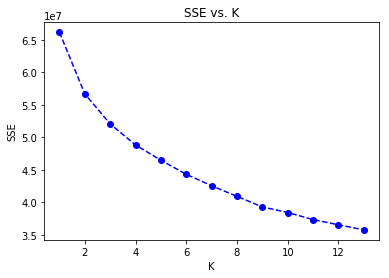

In [60]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the kmeans array
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,14))

for center in centers:
    scores.append(get_kmeans_score(pca_azdias1_transformed, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [61]:
# I stopped at 14 clusters as the time consumption was umbearable... 

In [62]:
#As we did not see a distinct elbow, I investigate below the cluster 10-16 below 
#to see if we can find out something in the more granular view

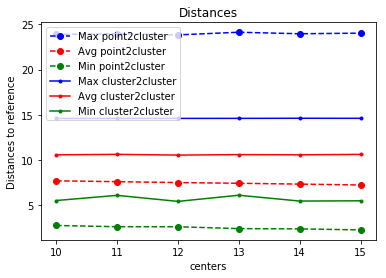

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
narr = pd.DataFrame(columns = ['clusters', 'max_intra_cluster', 'avg_intra_cluster', 'min_intra_cluster', 'max_cluster2cluster', 'avg_cluster2cluster', 'min_cluster2cluster'])
for num_clusters in list(range(10,16)):
    kmeans = KMeans(n_clusters = num_clusters)
    km = kmeans.fit(pca_azdias1_transformed)  

    labels = kmeans.predict(pca_azdias1_transformed)
    vectors = kmeans.transform(pca_azdias1_transformed)
    intra_distances = np.fromiter((math.fabs(row[index]) for row, index in zip(vectors, labels)), dtype=float)
    max_intra_dist, avg_intra_dist, min_intra_dist = intra_distances.__abs__().max(), intra_distances.__abs__().mean(), intra_distances.__abs__().min()

    dists = euclidean_distances(kmeans.cluster_centers_)
    if (num_clusters>1):
        tri_dists = dists[np.triu_indices(num_clusters, 1)]
        max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
    else:
        max_dist = 0 
        avg_dist = 0
        min_dist = 0

    narr.loc[num_clusters] = [num_clusters, max_intra_dist, avg_intra_dist, min_intra_dist, max_dist, avg_dist, min_dist]

l1 = plt.plot('clusters', 'max_intra_cluster', data=narr, linestyle='--', marker='o', color='b', label = 'Max point2cluster');
l2 = plt.plot('clusters', 'avg_intra_cluster', data=narr, linestyle='--', marker='o', color='r', label = 'Avg point2cluster');
l3 = plt.plot('clusters', 'min_intra_cluster', data=narr, linestyle='--', marker='o', color='g', label = 'Min point2cluster');
l4 = plt.plot('clusters', 'max_cluster2cluster', data=narr, linestyle='-', marker='.', color='b', label = 'Max cluster2cluster');
l5 = plt.plot('clusters', 'avg_cluster2cluster', data=narr, linestyle='-', marker='.', color='r', label = 'Avg cluster2cluster');
l6 = plt.plot('clusters', 'min_cluster2cluster', data=narr, linestyle='-', marker='.', color='g', label = 'Min cluster2cluster');

pylab.legend(loc='upper left')
plt.xlabel('centers');
plt.ylabel('Distances to reference');
plt.title('Distances');
plt.show();
plt.close('all')

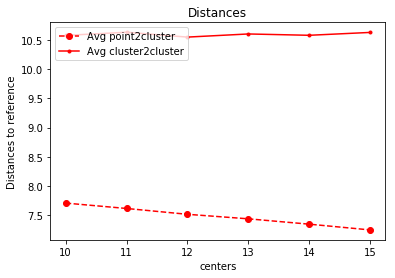

In [64]:
l1 = plt.plot('clusters', 'avg_intra_cluster', data=narr, linestyle='--', marker='o', color='r', label = 'Avg point2cluster');
l2 = plt.plot('clusters', 'avg_cluster2cluster', data=narr, linestyle='-', marker='.', color='r', label = 'Avg cluster2cluster');

pylab.legend(loc='upper left')
plt.xlabel('centers');
plt.ylabel('Distances to reference');
plt.title('Distances');
plt.show();
plt.close('all')

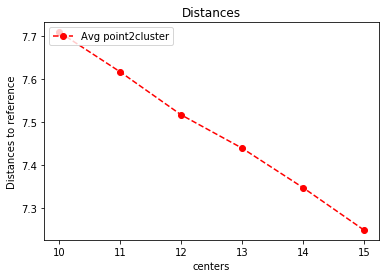

In [65]:
l2 = plt.plot('clusters', 'avg_intra_cluster', data=narr, linestyle='--', marker='o', color='r', label = 'Avg point2cluster');

pylab.legend(loc='upper left')
plt.xlabel('centers');
plt.ylabel('Distances to reference');
plt.title('Distances');
plt.show();
plt.close('all')

In [146]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# We select 13 clusters from the scree plot above. The is no distinct elbow, but we can possibly 
#see some flatting out of the curve there (p2cluster) and cluster2cluster is not jumping around, which is good. 
#A bad possible worse choice would be clusters=12 where we see cluster2cluster distance to drop, i.e. very close centers
num_clusters = 13
kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(pca_azdias1_transformed)  
vectors = kmeans.transform(pca_azdias1_transformed)
labels = kmeans.predict(pca_azdias1_transformed)
#distances = np.fromiter((row[index] for row, index in zip(vectors, labels)), dtype=float)
#pd_distances = pd.DataFrame(distances)
#print(pd_distances.head())


In [147]:
population_labels = pd.DataFrame(labels)
population_labels.columns = ['label']


### Discussion 3.1: Apply Clustering to General Population

I chose 13 clusters. As I could not see a distinct elbow in the elbow-chart, I dug into the cluster2cluster distances in relations to the point2cluster distances. Following the discussion about an erratic KMeans behaviour for 12 clusters, 13 was chosen where cluster2cluster distance was kept low along with falling point2cluster distances. Please look at the charts above to follow my deductions

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [148]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.name="Customers"


In [149]:
print(customers.columns.values)
customers.shape

['AGER_TYP' 'ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'CJT_GESAMTTYP'
 'FINANZ_MINIMALIST' 'FINANZ_SPARER' 'FINANZ_VORSORGER' 'FINANZ_ANLEGER'
 'FINANZ_UNAUFFAELLIGER' 'FINANZ_HAUSBAUER' 'FINANZTYP' 'GEBURTSJAHR'
 'GFK_URLAUBERTYP' 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'LP_LEBENSPHASE_FEIN'
 'LP_LEBENSPHASE_GROB' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB'
 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'NATIONALITAET_KZ'
 'PRAEGENDE_JUGENDJAHRE' 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL'
 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM'
 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'ALTER_HH' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'HH_EINKOMMEN_SCORE' 'KK_KUNDENTYP' 'W_KEIT_KIND_HH' 'WOHNDAUER_2008'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'GEBAEUDETYP' 'KONSUMNAEHE'
 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'WOHNLAGE' 'CAMEO_DEUG_2015'
 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' 'KBA05_ANTG1' 'KBA05_ANTG2'
 'KBA05_ANTG3' 'KBA05_AN

(191652, 85)

In [150]:
#customers.columns.shape

In [151]:
#customers['PRAEGENDE_JUGENDJAHRE'].map(pj_wrangling).unique()

In [152]:
#customers['DECADE'], customers['MOVEMENT'] = zip(*customers['PRAEGENDE_JUGENDJAHRE'].map(pj_wrangling))

In [153]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

custs_cleaned = clean_data(customers, thresh_=threshold1) # fully clean the row data from bad data quality
custs_cleaned.shape

(115643, 268)

In [154]:
custs_cleaned.columns.values

array(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ_1', 'ANRE

In [155]:
azdias1.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ_1', 'ANREDE_KZ_2',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2',
       'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5',
       'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8',
       'CAMEO_DEUG_2015_9', 'CAMEO_DEU_2015_1A', 'CAMEO_DEU_2015_1B',
       'CAMEO_DEU_2015_1C', 'CAMEO_DEU_2015_1D', 'CAMEO_DEU_2015_1E',
       'CAMEO_DEU_2015_2A', 'CAMEO_DEU_2015_2B', 'CAMEO_DEU_2015_2C',
       'CAMEO_DEU_2015_2D', 'CAMEO_DEU_2015_3A', 'CAMEO_DEU_2015_3B',
       'CAMEO_DEU_2015_3C', 'CAMEO_DEU_2015_3D', 'CAMEO_DEU_2015_4A',
       'CAMEO_DEU_2015_4B', 'CAMEO_DEU_2015_4C', 'CAMEO_DEU_2015_4D',
       'CAMEO_DEU_2015_4E', 'CAMEO_DEU_2015_5A', 'CAMEO_DEU_2015_5B',
       'CAMEO_DEU_2015_5C', 'CAMEO_DEU_2015_5D', 'CAMEO_DEU_2015_5E',
       'CAMEO_DEU_2015_5F', 'CAMEO_DEU_2015_6A', 'CAMEO_DEU_2015_6B',
       'CAMEO_DEU_2015_

In [156]:
print('Missing columns in custs_cleaned vs azdias1: {}'.format(azdias1.columns ^ custs_cleaned.columns))
#print('Missing columns in custs_cleaned vs custs1: {}'.format(custs1.columns ^ custs_cleaned.columns))
print('Making amendments...') # We add the missing column filled with zeros
custs_cleaned, azdias1 = custs_cleaned.align(azdias1, axis=1, fill_value=0)
custs_cleaned.shape

Missing columns in custs_cleaned vs azdias1: Index(['GEBAEUDETYP_5.0', 'WOHNLAGE_0.0'], dtype='object')
Making amendments...


(115643, 270)

In [77]:
def printer_opt(a,b,c):
    ta=a
    tb=b
    tc=c
    a= pd.get_option('display.max_rows')
    b= pd.get_option('display.max_columns')
    c= pd.get_option('display.width')

    pd.set_option('display.max_rows', ta)
    pd.set_option('display.max_columns', tb)
    pd.set_option('display.width', tc)
    return a,b,c

In [78]:
ap=500
bp=500
cp=1000
printer_opt(ap,bp,cp)
print(custs1.head(10).T)
print(custs1.shape)

                              0       2       4       5       6       7       9       11      12      14
ALTERSKATEGORIE_GROB         4.0     4.0     3.0     3.0     4.0     4.0     3.0     4.0     4.0     4.0
ANREDE_KZ_1                  1.0     0.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0
ANREDE_KZ_2                  0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0
ANZ_HAUSHALTE_AKTIV          1.0     1.0     7.0     1.0     1.0     1.0     1.0     1.0     1.0     9.0
ANZ_HH_TITEL                 0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
ANZ_PERSONEN                 2.0     1.0     4.0     2.0     2.0     2.0     3.0     1.0     3.0     1.0
ANZ_TITEL                    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
ARBEIT                       1.0     3.0     3.0     3.0     2.0     3.0     3.0     2.0     1.0     3.0
BALLRAUM                     3.0     7.0     3.0     7.

In [79]:
print(custs_cleaned.head(10).T)
print(custs_cleaned.shape)

                              0       2       4       5       6       7       9       11      12      14
ALTERSKATEGORIE_GROB         4.0     4.0     3.0     3.0     4.0     4.0     3.0     4.0     4.0     4.0
ANREDE_KZ_1                  1.0     0.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0
ANREDE_KZ_2                  0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0
ANZ_HAUSHALTE_AKTIV          1.0     1.0     7.0     1.0     1.0     1.0     1.0     1.0     1.0     9.0
ANZ_HH_TITEL                 0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
ANZ_PERSONEN                 2.0     1.0     4.0     2.0     2.0     2.0     3.0     1.0     3.0     1.0
ANZ_TITEL                    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
ARBEIT                       1.0     3.0     3.0     3.0     2.0     3.0     3.0     2.0     1.0     3.0
BALLRAUM                     3.0     7.0     3.0     7.

In [157]:
#Same as custs1_sc = scaler.fit_transform(custs1)
#Change per recommendation - PvR
cust_clean_sc = scaler.transform(custs_cleaned)
print(cust_clean_sc)


[[ 1.17630677  1.02267813 -1.02267813 ... -0.6090662  -0.33713312
  -0.30931069]
 [ 1.17630677 -0.97782476  0.97782476 ... -0.6090662  -0.33713312
  -0.30931069]
 [ 0.20210748  1.02267813 -1.02267813 ... -0.6090662  -0.33713312
  -0.30931069]
 ...
 [ 1.17630677  1.02267813 -1.02267813 ... -0.6090662  -0.33713312
  -0.30931069]
 [ 0.20210748 -0.97782476  0.97782476 ... -0.6090662  -0.33713312
  -0.30931069]
 [-0.77209181  1.02267813 -1.02267813 ... -0.6090662  -0.33713312
  -0.30931069]]


/smalltank/udacity/miniconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [158]:
#Same as pca_custs1_transformed = pca_azdias_final.transform(custs1_sc)# Apply PCA on sample i.e. customers
pca_cust_clean_transformed = pca_azdias_final.transform(cust_clean_sc)

In [159]:
printer_opt(ap,bp,cp) #Reset print options

(50, 50, 100)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [160]:
pca_cust_clean_labels = kmeans.predict(pca_cust_clean_transformed) # Apply PCA on sample i.e. customers
pd_cust_clean_labels = pd.DataFrame(pca_cust_clean_labels)
pd_cust_clean_labels.columns = ['label']
print(pd_cust_clean_labels.head(50).T)

       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
label   2   2   5  12   2   2  10   2  10   6  11  11  11   9   3   5   7   5   7  10   7  12   6   6   2  12   6   2  11   2   7   5  11   4   2   2  12   7   7  10  12   7  11   4  12  11   3  10   2   3


In [ ]:
#pca_custs1_labels = kmeans.predict(pca_custs1_transformed) # Apply PCA on sample i.e. customers
#pd_custs1_labels = pd.DataFrame(pca_custs1_labels)
#pd_custs1_labels.columns = ['label']
#print(pd_custs1_labels.head(50).T)

In [ ]:
#pd_custs1_labels.shape

In [161]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population. - THIS IS USING THE CLEAN_DATA FUNCTION
pop=[]
sample=[]
p_pop=[]
p_sample=[]
for i in range(num_clusters):
    pop.append(sum(population_labels['label']==i))
    sample.append(sum(pd_cust_clean_labels['label']==i))

for i in range(num_clusters):
    p_pop.append(pop[i]/sum(pop)*100.0)
    p_sample.append(sample[i]/sum(sample)*100.0)

print('Population')
for i in range(num_clusters):
    print('# in cluster {}: {:0.1f}%'.format(i, p_pop[i]))
print('Sample (i.e. customers)')
for i in range(num_clusters):
    print('# in cluster {}: {:0.1f}%'.format(i, p_sample[i]))


Population
# in cluster 0: 5.3%
# in cluster 1: 10.1%
# in cluster 2: 6.9%
# in cluster 3: 8.1%
# in cluster 4: 9.3%
# in cluster 5: 10.3%
# in cluster 6: 9.4%
# in cluster 7: 12.2%
# in cluster 8: 3.5%
# in cluster 9: 8.5%
# in cluster 10: 5.8%
# in cluster 11: 6.2%
# in cluster 12: 4.4%
Sample (i.e. customers)
# in cluster 0: 5.6%
# in cluster 1: 0.7%
# in cluster 2: 16.6%
# in cluster 3: 6.9%
# in cluster 4: 1.2%
# in cluster 5: 6.1%
# in cluster 6: 6.0%
# in cluster 7: 18.2%
# in cluster 8: 1.0%
# in cluster 9: 0.6%
# in cluster 10: 4.7%
# in cluster 11: 20.7%
# in cluster 12: 11.6%


In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population. - THIS IS CUSTOMERS FOLLOWING AZDIAS FROM THE START
'''
pop=[]
sample2=[]
p_pop=[]
p_sample2=[]
for i in range(num_clusters):
    pop.append(sum(population_labels['label']==i))
    sample2.append(sum(pd_custs1_labels['label']==i))

for i in range(num_clusters):
    p_pop.append(pop[i]/sum(pop)*100.0)
    p_sample2.append(sample2[i]/sum(sample2)*100.0)

print('Population')
for i in range(num_clusters):
    print('# in cluster {}: {:0.1f}%'.format(i, p_pop[i]))
print('Sample (i.e. customers)')
for i in range(num_clusters):
    print('# in cluster {}: {:0.1f}%'.format(i, p_sample2[i]))
'''

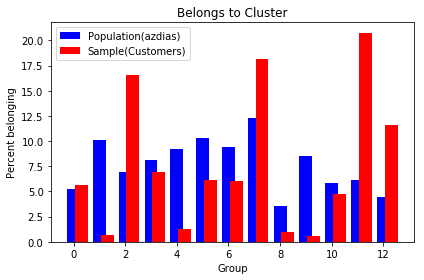

In [162]:
index = np.arange(num_clusters)
bar_width = 0.5
fig, ax = plt.subplots()
rects1 = ax.bar(index, p_pop, bar_width, color='b', label='Population(azdias)')
rects2 = ax.bar(index+bar_width-0.2, p_sample, bar_width, color='r', label='Sample(Customers)')
ax.set_xlabel('Group')
ax.set_ylabel('Percent belonging')
ax.set_title('Belongs to Cluster')
ax.legend()
fig.tight_layout()
plt.show()

In [163]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
p_diff=[]
index_p=[]
index_c=[]
for i in range(len(p_pop)):
    p_diff.append(p_sample[i]-p_pop[i])
    index_p.append(str(i))
p_diff=pd.DataFrame(p_diff)
p_diff.columns = ['overweight']
p_diff['index']=index_p
a=p_diff.sort_values(by='overweight', ascending=False)
highest=int(a['index'].iloc[0])
centers = pca_azdias_final.inverse_transform(kmeans.cluster_centers_)
c=pd.DataFrame(centers[highest])
c.columns = ['weight']
for i in range(c.shape[0]):
    index_c.append(i)
c['category']=index_c
c['names']=azdias1.columns.values.T
c['abs_weight'] = c['weight'].abs()
print('Cluster {}'.format(highest))
print(c.sort_values(by=['abs_weight'], ascending=False).head(10))


Cluster 11
       weight  category                     names  abs_weight
195  2.138337       195       LP_STATUS_FEIN_10.0    2.138337
208  2.138337       208        LP_STATUS_GROB_5.0    2.138337
114  1.835062       114          GREEN_AVANTGARDE    1.835062
211  1.835062       211       MOVEMENT_Avantgarde    1.835062
212 -1.835062       212       MOVEMENT_Mainstream    1.835062
141  1.673607       141       LP_FAMILIE_GROB_5.0    1.673607
116 -1.509627       116        HH_EINKOMMEN_SCORE    1.509627
5    1.328129         5              ANZ_PERSONEN    1.328129
185  1.278109       185  LP_LEBENSPHASE_GROB_12.0    1.278109
127  1.218686       127      LP_FAMILIE_FEIN_10.0    1.218686


In [164]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
p_diff=[]
index_p=[]
index_c=[]
for i in range(len(p_pop)):
    p_diff.append(p_sample[i]-p_pop[i])
    index_p.append(str(i))
p_diff=pd.DataFrame(p_diff)
p_diff.columns = ['overweight']
p_diff['index']=index_p
a=p_diff.sort_values(by='overweight', ascending=True)
lowest=int(a['index'].iloc[0])
centers = pca_azdias_final.inverse_transform(kmeans.cluster_centers_)
c=pd.DataFrame(centers[lowest])
c.columns = ['weight']
for i in range(c.shape[0]):
    index_c.append(i)
c['category']=index_c
c['names']=azdias1.columns.values.T
c['abs_weight'] = c['weight'].abs()
print('Cluster {}'.format(lowest))
print(c.sort_values(by=['abs_weight'], ascending=False).head(10))



Cluster 1
       weight  category                    names  abs_weight
93  -1.463702        93        FINANZ_MINIMALIST    1.463702
241  1.334233       241                SEMIO_RAT    1.334233
85   1.300368        85              FINANZTYP_1    1.300368
182  1.277382       182  LP_LEBENSPHASE_GROB_1.0    1.277382
196  1.275791       196       LP_STATUS_FEIN_2.0    1.275791
94   1.242349        94            FINANZ_SPARER    1.242349
0   -1.105171         0     ALTERSKATEGORIE_GROB    1.105171
142  1.101837       142  LP_LEBENSPHASE_FEIN_1.0    1.101837
96  -1.084132        96         FINANZ_VORSORGER    1.084132
83   1.080437        83              DECADE_1990    1.080437


### Discussion 3.3: Compare Customer Data to Demographics Data

Over represented in the customerbase compared to the population(Azdias) we find: 

LP_STATUS_FEIN = 10, LP_STATUS_GROB = 5, GREEN_AVANTGARDE, MOVEMENT_Avantgarde, FINANZ_MINIMALIST

Under represented in the data was: 

MOVEMENT_Mainstream, HH_EINKOMMEN_SCORE, LP_LEBENSPHASE_GROB = 1, LP_LEBENSPHASE_FEIN = 1, LP_STATUS_FEIN = 2, FINANZ_SPARER

Also we can possibly, because of the same data columns show up the under represted and over represented clusters with different signs above, see that we could drop even more columns and have less clusters the next time - i.e. the data is correlated. 

So, looking into the descriptions for the columns given above we find the following.

The customerbase is baised towards being involved in environmental sustainability questions, on the "barricades" (avantgarde), top earners, have little debt(finanz_minimalist) etc.

We can see that an underrepresented customer base (and could be considered as possibility for approaching) is: Mainstream people (MOVEMENT_Mainstream), Low income people (HH_EINKOMMEN_SCORE, LP_STATUS_GROB) and especially single low-income earners of middle age (LP_STATUS_FEIN = 2, LP_LEBENSPHASE_GROB = 1), Money savers (FINANZ_SPARER)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.